In [1]:
import pandas as pd
import rdkit
from rdkit import Chem
import prody
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors, Crippen, QED

import crem
from crem.crem import mutate_mol, grow_mol, link_mols

import fegrow
from fegrow import ChemSpace
from fegrow.al import Model, Query

import dask
from dask.distributed import LocalCluster

### Prepared for the ligand template

#### Load the Molecule from a SDF file
In here, using the RDKit to read the first file from a SDF file, and return a molecule (Mol object)

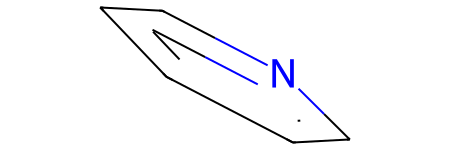

In [2]:
scaffold = Chem.SDMolSupplier('5R83_core.sdf')[0]
scaffold

#### Visualise the Molecule with Atom Indices 
In this step, Using **FEgrow** to convert the RDKit molecule into a format that allows for visualisation and interaction

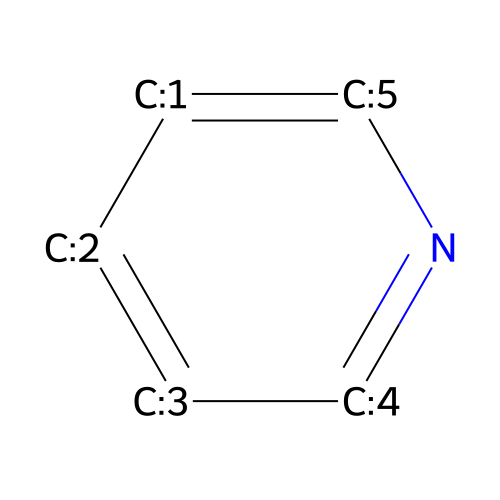

In [3]:
toview = fegrow.RMol(scaffold)
toview.rep2D(idx=True, size=(500, 500))

#### Generate New Molecules from the Scaffold with CReM
In this stage, using the **CReM** (Chemically Resonable Mutations framework for structure generation) to grow new molecules by fragment replacement.

A list of new molecules generated by replacing parts of the scaffold with fragments.

Stored in the variable `smiles`, which contains SMILES strings.

In [4]:
smiles = list(grow_mol(scaffold, db_name='chembl22_sa25_hac12.db', max_atoms=10, ncores=10))
smiles

[16:59:33] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:59:33] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:59:33] WARNING: not removing hydrogen atom with dummy atom neighbors


['Brc1ccc(-c2ccccn2)cc1',
 'Brc1ccccc1SCc1ccccn1',
 'Brc1ccc(CSc2ccccn2)cc1',
 'Brc1ccc(CSCc2ccccn2)cc1',
 'Brc1ccc(Nc2ccccn2)cc1',
 'Brc1ccc(NCc2ccccn2)cc1',
 'Brc1ccc(Sc2ccccn2)cc1',
 'Brc1ccc(SCc2ccccn2)cc1',
 'Brc1ccc(SCCc2ccccn2)cc1',
 'Brc1cnc(Nc2ccccn2)s1',
 'Brc1cnn(-c2ccccn2)c1',
 'Cc1ccccn1',
 'c1ccc(-c2cc3n(n2)CCCC3)nc1',
 'c1ccc(C2CC2)nc1',
 'c1ccc(CSc2nnc(C3CC3)s2)nc1',
 'c1ccc(-c2ccncc2)nc1',
 'c1ccc(NCC2CC2)nc1',
 'c1ccc(-c2ccoc2)nc1',
 'c1ccc(OCC2CC2)nc1',
 'c1ccc(-c2ccsc2)nc1',
 'c1ccc(NC2CC2)nc1',
 'c1ccc(-c2ccnc3ncnn23)nc1',
 'c1ccc(-c2ccc3[nH]ccc3c2)nc1',
 'c1ccc(Nc2ccc3c(c2)OCO3)nc1',
 'c1ccc(Sc2ccc3c(c2)CCC3)nc1',
 'c1ccc(-c2nc3ccncc3[nH]2)nc1',
 'c1ccc(-c2nccc3[nH]cnc23)nc1',
 'c1ccc(-c2nnc3ccncc3n2)nc1',
 'c1ccc(-c2ccccn2)cc1',
 'c1ccc(-c2ccccn2)nc1',
 'c1ccc(-c2cccc3ccccc23)nc1',
 'c1ccc(-c2cncc3ccccc23)nc1',
 'c1ccc(-c2csc3ccccc23)nc1',
 'c1ccc(-c2ccc3ccccc3c2)nc1',
 'c1ccc(NC2Cc3ccccc3C2)nc1',
 'c1ccc(N2CCc3ccccc3C2)nc1',
 'c1ccc(-n2nnc3ccccc32)nc1',
 'c1ccc(

In [5]:
len(smiles)

7725

####  Set Up a Dask Local Cluster

Before initialising the chemical space, we set up a **Dask LocalCluster** to enable parallel processing. This will speed up tasks like molecular property calculations, docking, and filtering in FeGrow.

In here, we allocate 1 worker × 4 threads = 4 threads of parallel processing power.


In [6]:
# CPU
lc = LocalCluster(processes=True, n_workers=1, threads_per_worker=4)

# GPU
# lc = LocalCUDACluster(n_workers=1, threads_per_worker=4)  # 1 worker per GPU

/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38359 instead
  warnings.warn(
2025-02-20 17:18:23,707 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:35473' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'_evaluate_atomic-309b2a62-f142-49b7-81c0-1343e3c009d6', '_evaluate_atomic-fef6ae19-e8e1-4535-88b2-367f7c694615', '_evaluate_atomic-889f3ce4-6f28-4131-9e43-75295d454ab5', '_evaluate_atomic-f1663482-86a5-4115-ac11-21815613052c', '_evaluate_atomic-a0c95a55-707f-431f-b2c5-9c6470b9a7ff', '_evaluate_atomic-678bdf34-3129-498a-ad10-3fe40ad8954d', '_evaluate_atomic-5c2d857b-705a-443d-a361-3f0b0c5508be', '_evaluate_atomic-72cc95b7-1a95-4963-9293-10c5e825d61e', '_evaluate_atomic-62678481-4408-41b7-9a31-e43aa20c6714', '_evaluate_atomic-8f5caede-2970-429

####  Create a Chemical Space Environment

We now create a `ChemSpace` object using **FEgrow**, which will serve as a container for managing, analysing, and scoring the molecules generated from the scaffold.

In [7]:
cs = ChemSpace(dask_cluster=lc)
cs

Dask can be watched on http://127.0.0.1:38359/status


Smiles 
 score 
 h 
 Training 
 Success 
 enamine_searched 
 enamine_id 
 2D

#### Add a Scaffold to the Chemical Space

In this step, we add a scaffold molecule to our Chemical Space (`cs`) and then display its contents.

The scaffold serves as the core chemical structure and defines the binding bound region for later evaluation


In [8]:
cs.add_scaffold(scaffold)
cs

/home/campus.ncl.ac.uk/c2033567/.local/lib/python3.10/site-packages/fegrow/package.py:799: UserWarning: The template does not have an attachement (Atoms with index 0, or in case of Smiles the * character. )
  warnings.warn("The template does not have an attachement (Atoms with index 0, "


Smiles 
 score 
 h 
 Training 
 Success 
 enamine_searched 
 enamine_id 
 2D

#### Prepare and Add the Receptor (Protein) Structure

The protein structure is first parsed and cleaned to remove nucleic acids, heteroatoms, and water molecules, keeping only the protein residues. Next, the receptor is corrected and completed by adding any missing atoms and hydrogens at the desired pH. Finally, the prepared receptor is added into the chemical space.

In [9]:
# get the protein-ligand complex structure
#!wget -nc https://files.rcsb.org/download/3vf6.pdb

# load the complex with the ligand
sys = prody.parsePDB('5R83_final.pdb')

# remove any unwanted molecules
rec = sys.select('not (nucleic or hetatm or water)')

# save the processed protein
prody.writePDB('rec.pdb', rec)

# fix the receptor file (missing residues, protonation, etc)
fegrow.fix_receptor("rec.pdb", "rec_final.pdb")

# load back into prody
#rec_final = prody.parsePDB("rec_final.pdb")
#rec_final = prody.parsePDB("out.pdb")

# fix the receptor file (missing residues, protonation, etc)
##fegrow.fix_receptor("7t79-H-prep.pdb", "rec_final.pdb")

# load back into prody
##rec_final = prody.parsePDB("rec_final.pdb")

#!grep "ATOM" ../structures/7t79-H.pdb > rec_final.pdb
#cs.add_protein(rec_5R83_path)
cs.add_protein('rec_final.pdb')

@> 4656 atoms and 1 coordinate set(s) were parsed in 0.03s.


#### Protonate and Sanitize Molecules

In this step, each molecule is protonated and sanitised to ensure it is chemically valid before further processing,
each molecule is checked and standardised through sanitisation, which ensures such as proper bond structures, valence states and aromaticity. Invalid molecules that fail these checks due to structural or valence errors are excluded from further analysis. 

In [10]:
# protonat
valid_smiles = []
for smi in smiles:
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    try:
        # Sanitise the molecules
        Chem.SanitizeMol(mol)
        valid_smi = Chem.MolToSmiles(mol)
        valid_smiles.append(valid_smi)
    except ValueError as e:
        print(f"Sanitisation failed: {e}")

In [11]:
valid_smiles

['[H]c1nc(-c2c([H])c([H])c(Br)c([H])c2[H])c([H])c([H])c1[H]',
 '[H]c1nc(C([H])([H])Sc2c([H])c([H])c([H])c([H])c2Br)c([H])c([H])c1[H]',
 '[H]c1nc(SC([H])([H])c2c([H])c([H])c(Br)c([H])c2[H])c([H])c([H])c1[H]',
 '[H]c1nc(C([H])([H])SC([H])([H])c2c([H])c([H])c(Br)c([H])c2[H])c([H])c([H])c1[H]',
 '[H]c1nc(N([H])c2c([H])c([H])c(Br)c([H])c2[H])c([H])c([H])c1[H]',
 '[H]c1nc(C([H])([H])N([H])c2c([H])c([H])c(Br)c([H])c2[H])c([H])c([H])c1[H]',
 '[H]c1nc(Sc2c([H])c([H])c(Br)c([H])c2[H])c([H])c([H])c1[H]',
 '[H]c1nc(C([H])([H])Sc2c([H])c([H])c(Br)c([H])c2[H])c([H])c([H])c1[H]',
 '[H]c1nc(C([H])([H])C([H])([H])Sc2c([H])c([H])c(Br)c([H])c2[H])c([H])c([H])c1[H]',
 '[H]c1nc(N([H])c2nc([H])c([H])c([H])c2[H])sc1Br',
 '[H]c1nc(-n2nc([H])c(Br)c2[H])c([H])c([H])c1[H]',
 '[H]c1nc(C([H])([H])[H])c([H])c([H])c1[H]',
 '[H]c1nc(-c2nn3c(c2[H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])c([H])c([H])c1[H]',
 '[H]c1nc(C2([H])C([H])([H])C2([H])[H])c([H])c([H])c1[H]',
 '[H]c1nc(C([H])([H])Sc2nnc(C3([H])C([H])([H])C3([

In [12]:
len(valid_smiles)

7725

#### Add Validated SMILES to the Chemical Space

In this step, the filtered and validated molecules, represented as SMILES strings, are added to the chemical space. The added molecules have already been screened to meet drug-likeness criteria, including compliance with Lipinski’s Rule of Five, achieving an acceptable QED score, and successfully undergoing sanitization and protonation during preprocessing.

In [13]:
cs.add_smiles(valid_smiles)

Smiles 
 score 
 h 
 Training 
 Success 
 enamine_searched 
 enamine_id 
 2D 
 
 
 
 
 0 
 [H]c1nc(-c2c([H])c([H])c(Br)c([H])c2[H])c([H])... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 
 
 
 1 
 [H]c1nc(C([H])([H])Sc2c([H])c([H])c([H])c([H])... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 
 
 
 2 
 [H]c1nc(SC([H])([H])c2c([H])c([H])c(Br)c([H])c... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 
 
 
 3 
 [H]c1nc(C([H])([H])SC([H])([H])c2c([H])c([H])c... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 
 
 
 4 
 [H]c1nc(N([H])c2c([H])c([H])c(Br)c([H])c2[H])c... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 7720 
 [H]c1nc([H])c(S(=O)(=O)N2C([H])([H])C([H])([H]... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 
 
 
 7721 
 [H]c1nc([H])c(S(=O)(=O)N2C([H])([H])C([H])([H]... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 
 
 
 7722 
 [H]c1nc([H])c(S(=O)(=O)N2C([H])([H])C([H])([H]... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 
 
 
 7723 
 [H]c1nc([H])c(C([H])([H])N([H])S(=O)(=O)c2sc([... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 
 
 
 7724 
 [H]c1nc([H])c(S(=O)(=O)N([H])C2([H])C([H])([H]... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 
 
 
 
 7725 rows × 8 columns
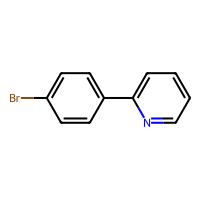
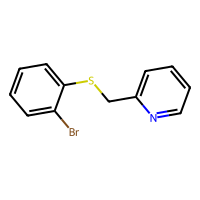
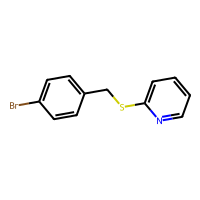
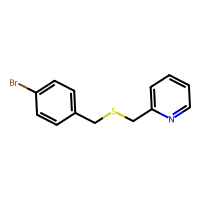
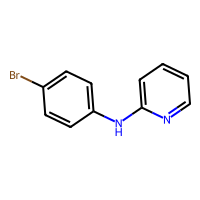
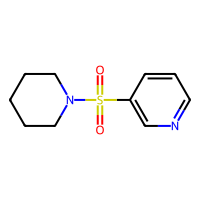
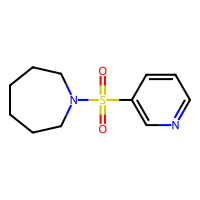
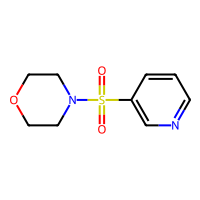
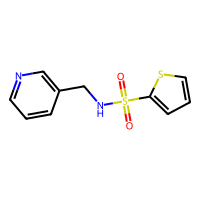
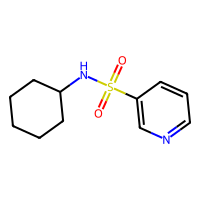

In [14]:
cs

#### Active Learning

In this step, active learning is initiated to select a group of compounds for evaluation. In the first round, 50 molecules are randomly selected to form the initial training set, since no predictive model has yet been established.

In [15]:
# Randomly initialise active learning
random1 = cs.active_learning(50, first_random=True)
random1

/home/campus.ncl.ac.uk/c2033567/.local/lib/python3.10/site-packages/fegrow/package.py:1275: UserWarning: Selecting randomly the first samples to be studied (no score data yet). 
  warnings.warn("Selecting randomly the first samples to be studied (no score data yet). ")


Smiles  \
5311  [H]OC(=O)C([H])(N([H])C(=O)C([H])([H])N([H])[H...   
6380  [H]c1nsnc1C(=O)N([H])C([H])([H])c1c([H])c([H])...   
36    [H]c1nc(-n2nnc3c([H])c([H])c([H])c([H])c32)c([...   
2115  [H]OC([H])([H])C([H])([H])c1c(C([H])([H])[H])n...   
1628  [H]c1nc([H])c([H])c(C([H])([H])C(=O)N2C([H])([...   
5150  [H]c1nc([H])c([H])c(-c2nc(C#N)c(N([H])[H])o2)c...   
4522  [H]c1nc(SC([H])([H])[H])nc(Oc2c([H])c([H])nc([...   
639   [H]Oc1c([H])c([H])c(Oc2nc([H])c([H])c([H])c2[H...   
5803  [H]c1nc([H])c([H])c(-c2c([H])c([H])c3sc(=O)n([...   
1318  [H]c1nn(C([H])([H])c2c([H])c([H])nc([H])c2[H])...   
4609  [H]c1nc([H])c([H])c(-c2c([H])c([H])c([H])c(F)c...   
3351  [H]c1nc([H])c([H])c(-n2nc(OC([H])([H])C(=O)C([...   
6391  [H]c1nc([H])c([H])c(N([H])C(=O)N([H])C2([H])C(...   
3641  [H]c1nc([H])c([H])c(C([H])([H])Sc2c([H])c([H])...   
6974  [H]c1nc([H])c(-c2nc3c([H])c([H])c([H])c([H])c3...   
1906  [H]c1nc([H])c([H])c(C([H])([H])n2c([H])c(C([H]...   
2140  [H]c1nc([H])c([H])c(C([H])([H])n2nc(C([H])([H]...   
4884  [H]c1nc([H])c([H])c(C([H])([H])c2c([H])nc(N([H...   
2085  [H]c1nc(C([H])([H])[H])c(-c2c([H])c([H])nc([H]...   
4876  [H]c1nc([H])c([H])c(-c2c([H])nc(N([H])[H])n2C2...   
3221  [H]c1nc([H])c([H])c(C([H])(N([H])C(=O)N2C([H])...   
200   [H]c1nc(N([H])C([H])([H])c2onc(C([H])([H])[H])...   
882   [H]c1nc([H])c([H])c(OC([H])([H])C2([H])C([H])(...   
340   [H]c1nc(N([H])C(=O)c2c([H])c([H])nn2C([H])([H]...   
7477  [H]c1nc([H])c(C([H])([H])n2nc([H])c([H])c2N([H...   
2863  [H]c1nc([H])c([H])c(OC(=O)N(C([H])([H])[H])C([...   
5893  [H]OC([H])([H])C([H])([H])c1c([H])c([H])nc([H]...   
554   [H]c1nc(Oc2c([H])c([H])c(F)c([H])c2F)c([H])c([...   
3155  [H]OC([H])(c1c([H])c([H])nc([H])c1[H])C([H])([...   
5642  [H]c1nc([H])c([H])c(C([H])([H])n2c(=O)c([H])c(...   
7194  [H]c1nc([H])c(C(=O)N([H])C([H])([H])C([H])(C([...   
6437  [H]c1nsnc1N([H])C(=O)N([H])c1c([H])c([H])nc([H...   
2025  [H]c1nc([H])c([H])c(N([H])C(=O)c2oc(C([H])([H]...   
6360  [H]c1nc([H])c([H])c(C([H])([H])N([H])C(=O)C2([...   
3735  [H]C1=C(c2c([H])c([H])nc([H])c2[H])C([H])([H])...   
1381  [H]c1nc(-c2c([H])c([H])nc([H])c2[H])c2c([H])c(...   
3953  [H]c1nc(N([H])C([H])([H])[H])nc(-c2c([H])c([H]...   
2943  [H]OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H...   
4033  [H]c1nc([H])c([H])c(C([H])([H])N(C([H])([H])[H...   
2175  [H]c1nc([H])c([H])c(C(=O)N(c2nnc(C([H])([H])[H...   
4075  [H]c1nc([H])c([H])c(N([H])C(=O)C([H])([H])C([H...   
6716  [H]OC(=O)C([H])([H])C([H])(C([H])([H])O[H])C([...   
5549  [H]Oc1c([H])c([H])c2c([H])c(-c3c([H])c([H])nc(...   
6973  [H]c1nc([H])c(-c2c([H])nc3c([H])c([H])c([H])c(...   
2847  [H]c1nc([H])c([H])c(C([H])(N([H])C(=O)C([H])([...   
1659  [H]c1nc([H])c([H])c(C([H])([H])C(=O)c2oc(C([H]...   
7137  [H]c1nc([H])c(C(=O)N([H])c2nc(C([H])([H])[H])c...   
4571  [H]c1nc([H])c([H])c(-c2c([H])c([H])c([H])c(S(=...   
6116  [H]OC([H])(C(F)(F)F)C([H])([H])C(=O)c1c([H])c(...   
659   [H]OC([H])([H])C([H])([H])C([H])([H])c1nc([H])...   

                                                   Mol score     h  Training  \
5311  <rdkit.Chem.rdchem.Mol object at 0x7b59ba281380>  <NA>  <NA>     False   
6380  <rdkit.Chem.rdchem.Mol object at 0x7b59ba2a2c70>  <NA>  <NA>     False   
36    <rdkit.Chem.rdchem.Mol object at 0x7b59ba4e31b0>  <NA>  <NA>     False   
2115  <rdkit.Chem.rdchem.Mol object at 0x7b59ba227680>  <NA>  <NA>     False   
1628  <rdkit.Chem.rdchem.Mol object at 0x7b59ba215e70>  <NA>  <NA>     False   
5150  <rdkit.Chem.rdchem.Mol object at 0x7b59ba2735a0>  <NA>  <NA>     False   
4522  <rdkit.Chem.rdchem.Mol object at 0x7b59ba239bd0>  <NA>  <NA>     False   
639   <rdkit.Chem.rdchem.Mol object at 0x7b59ba4ba9d0>  <NA>  <NA>     False   
5803  <rdkit.Chem.rdchem.Mol object at 0x7b59ba292dc0>  <NA>  <NA>     False   
1318  <rdkit.Chem.rdchem.Mol object at 0x7b59ba2095b0>  <NA>  <NA>     False   
4609  <rdkit.Chem.rdchem.Mol object at 0x7b59ba2286d0>  <NA>  <NA>     False   
3351  <rdkit.Chem.rdchem.Mol object at 0x7b59ba259770>  <NA>  <NA>     False   

#### Evaluate the First Active Learning Batch

After selecting molecules through active learning, the next step is to evaluate them using FEgrow’s scoring pipeline. 

This process estimates the binding or docking performance of each selected compound, generating feedback data that will inform the next round of active learning. In this evaluation, a set of molecules from the first active learning round is analysed by generating up to 50 conformers per molecule to ensure thorough sampling of possible binding poses. 

The evaluation can be run using CPU computation, with GPU acceleration available for faster scoring if supported.

In [16]:
# now evaluate the first selection
random1_results = cs.evaluate(random1, num_conf=50, gnina_gpu=False, penalty=0.0, al_ignore_penalty=False)

/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords 

Generated 2 conformers. 
Removed 2 conformers. 
Generated 4 conformers. 
Generated 16 conformers. 
Removed 2 conformers. 
Generated 33 conformers. 
Removed 13 conformers. 
Removed 26 conformers. 
Generated 8 conformers. 
Removed 2 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/2 [00:00<?, ?it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash:

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  33%|███████▋               | 1/3 [00:05<00:10,  5.32s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  67%|███████████████▎       | 2/3 [00:09<00:04,  4.86s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/minico

Generated 41 conformers. 
Removed 17 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 4 conformers. 
Removed 4 conformers. 
Generated 12 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'
Removed 4 conformers. 


Optimising conformer:   0%|                               | 0/7 [00:00<?, ?it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  14%|███▎                   | 1/7 [00:02<00:13,  2.33s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  29%|██████▌                

Generated 31 conformers. 
Removed 15 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer: 100%|███████████████████████| 7/7 [00:14<00:00,  2.05s/it]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bas

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   6%|█▍                    | 1/16 [00:01<00:24,  1.64s/it]

Optimising conformer:   0%|                               | 0/8 [00:00<?, ?it/s]

failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:  54%|███████████▍         | 13/24 [00:13<00:12,  1.11s/it]

Optimising conformer:  12%|██▉                    | 1/8 [00:02<00:17,  2.47s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  79%|████████████████▋    | 19/24 [00:20<00:05,  1.19s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information 

Generated 42 conformers. 
Removed 34 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:  94%|███████████████████▋ | 15/16 [00:19<00:01,  1.30s/it]

Optimising conformer: 100%|█████████████████████| 16/16 [00:20<00:00,  1.29s/it]


Optimising conformer:  25%|█████▊                 | 2/8 [00:04<00:12,  2.16s/it]

Optimising conformer:  50%|███████████▌           | 4/8 [00:20<00:16,  4.23s/it]

Optimising conformer:  38%|████████▋              | 3/8 [00:06<00:10,  2.08s/it]

Optimising conformer: 100%|███████████████████████| 8/8 [00:16<00:00,  2.03s/it]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (

Generated 12 conformers. 
Removed 6 conformers. 
Generated 27 conformers. 
Removed 21 conformers. 
Generated 4 conformers. 
Removed 2 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  17%|███▊                   | 1/6 [00:02<00:11,  2.26s/it]

failed to equip `nnpops` with error: No module named 'NNPOps'




Optimising conformer:  33%|███████▋               | 2/6 [00:03<00:07,  1.83s/it]2025-02-20 17:02:15,668 - distributed.worker - ERROR - Compute Failed
Key:       _evaluate_atomic-db5ed8f4-1428-4a30-96f9-1108dcf0be13
State:     executing
Function:  execute_task
args:      ((<function apply at 0x71ec0c93fd90>, <function _evaluate_atomic at 0x71eaf9fb4790>, [<rdkit.Chem.rdchem.Mol object at 0x71ec0830f0b0>, '[H]c1nc(N([H])C([H])([H])c2onc(C([H])([H])[H])c2[H])c([H])c([H])c1[H]', 'rec_final.pdb'], (<class 'dict'>, [['h', None], ['num_conf', 50], ['minimum_conf_rms', 0.5], ['scoring_function', None], ['gnina_gpu', False]])))
kwargs:    {}
Exception: "Exception('No Conformers')"
Traceback: '  File "/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/dask/utils.py", line 78, in apply\n    return func(*args, **kwargs)\n  File "/home/campus.ncl.ac.uk/c2033567/.local/lib/python3.10/site-packages/fegrow/package.py", line 1723, in _evaluate_atomic\n    raise Ex

/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


Generated 11 conformers. 
Removed 11 conformers. 
Generated 33 conformers. 
Removed 22 conformers. 
Generated 17 conformers. 
Removed 17 conformers. 
Generated 7 conformers. 
Removed 7 conformers. 
Generated 8 conformers. 
Removed 8 conformers. 
Generated 4 conformers. 
Removed 2 conformers. 
Generated 4 conformers. 
Removed 1 conformers. 
Generated 41 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Removed 32 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   9%|██                    | 1/11 [00:01<00:19,  1.96s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:   0%|                               | 0/2 [00:00<?, ?it/s]

failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  36%|████████              | 4/11 [00:07<00:13,  1.92s/it]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:  11%|██▌                    | 1/9 [00:02<00:17,  2.13s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  55%|████████████          | 6/11 [00:11<00:09,  1.86s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  82%|██████████████████    | 9/11 [00:15<00:03,  1.60s/it]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'




Optimising conformer:  56%|████████████▊          | 5/9 [00:08<00:06,  1.63s/it]2025-02-20 17:02:58,699 - distributed.worker - ERROR - Compute Failed
Key:       _evaluate_atomic-9e19ad17-df9f-4a33-b8b1-69ec929b228f
State:     executing
Function:  execute_task
args:      ((<function apply at 0x71ec0c93fd90>, <function _evaluate_atomic at 0x71eaf9fb4790>, [<rdkit.Chem.rdchem.Mol object at 0x71ec0830f0b0>, '[H]c1nc(-n2nnc3c([H])c([H])c([H])c([H])c32)c([H])c([H])c1[H]', 'rec_final.pdb'], (<class 'dict'>, [['h', None], ['num_conf', 50], ['minimum_conf_rms', 0.5], ['scoring_function', None], ['gnina_gpu', False]])))
kwargs:    {}
Exception: "Exception('No Conformers')"
Traceback: '  File "/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/dask/utils.py", line 78, in apply\n    return func(*args, **kwargs)\n  File "/home/campus.ncl.ac.uk/c2033567/.local/lib/python3.10/site-packages/fegrow/package.py", line 1723, in _evaluate_atomic\n    raise Exception("

Generated 3 conformers. 
Removed 3 conformers. 
Generated 14 conformers. 
Removed 14 conformers. 
Generated 15 conformers. 
Removed 7 conformers. 
Generated 4 conformers. 
Removed 2 conformers. 
Generated 4 conformers. 
Removed 2 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 21 conformers. 
Removed 21 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'
Generated 16 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/


Optimising conformer:  50%|███████████▌           | 1/2 [00:00<00:00,  1.05it/s]2025-02-20 17:03:26,059 - distributed.worker - ERROR - Compute Failed
Key:       _evaluate_atomic-8d4ad5c9-6fdc-4e58-9472-1c6868d4977f
State:     executing
Function:  execute_task
args:      ((<function apply at 0x71ec0c93fd90>, <function _evaluate_atomic at 0x71eaf9fb4790>, [<rdkit.Chem.rdchem.Mol object at 0x71ec0830f0b0>, '[H]c1nc([H])c([H])c(-c2c([H])c([H])c([H])c(S(=O)(=O)C([H])([H])[H])c2[H])c1[H]', 'rec_final.pdb'], (<class 'dict'>, [['h', None], ['num_conf', 50], ['minimum_conf_rms', 0.5], ['scoring_function', None], ['gnina_gpu', False]])))
kwargs:    {}
Exception: "Exception('No Conformers')"
Traceback: '  File "/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/dask/utils.py", line 78, in apply\n    return func(*args, **kwargs)\n  File "/home/campus.ncl.ac.uk/c2033567/.local/lib/python3.10/site-packages/fegrow/package.py", line 1723, in _evaluate_atomic\n    r

Removed 16 conformers. 
Generated 2 conformers. 
Removed 0 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 2/2 [00:02<00:00,  1.26s/it]

Optimising conformer:  12%|██▉                    | 1/8 [00:02<00:19,  2.72s/it]

Generated 17 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'
Removed 15 conformers. 


Optimising conformer:   0%|                               | 0/2 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)

Optimising conformer:  25%|█████▊                 | 2/8 [00:04<00:13,  2.18s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer: 100%|███████████████████████| 2/2 [00:01<00:00,  1.08it/s]

Optimising conformer:  50%|███████████▌           | 4/8 [00:09<00:10,  2.52s/it]2025-02-20 17:03:47,375 - distributed.worker - ERROR - Compute Failed
Key:       _evaluate_atomic-7a044e08-5367-44df-ad70-dcb8dca0998d
State:     e

Generated 4 conformers. 
Removed 4 conformers. 
Generated 11 conformers. 
Removed 8 conformers. 
Generated 20 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Removed 20 conformers. 
Generated 13 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'
Removed 13 conformers. 
Generated 4 conformers. 
Removed 4 conformers. 


Optimising conformer:   0%|                               | 0/2 [00:00<?, ?it/s]2025-02-20 17:03:55,668 - distributed.worker - ERROR - Compute Failed
Key:       _evaluate_atomic-57dfa17a-3eee-45c6-b0b3-f1aa09c3a13e
State:     executing
Function:  execute_task
args:      ((<function apply at 0x71ec0c93fd90>, <function _evaluate_atomic at 0x71eaf9fb4790>, [<rdkit.Chem.rdchem.Mol object at 0x71ec0830f0b0>, '[H]c1nc(C([H])([H])[H])c(-c2c([H])c([H])nc([H])c2[H])o1', 'rec_final.pdb'], (<class 'dict'>, [['h', None], ['num_conf', 50], ['minimum_conf_rms', 0.5], ['scoring_function', None], ['gnina_gpu', False]])))
kwargs:    {}
Exception: "Exception('No Conformers')"
Traceback: '  File "/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/dask/utils.py", line 78, in apply\n    return func(*args, **kwargs)\n  File "/home/campus.ncl.ac.uk/c2033567/.local/lib/python3.10/site-packages/fegrow/package.py", line 1723, in _evaluate_atomic\n    raise Exception("No Conf

Generated 11 conformers. 
Removed 6 conformers. 
Generated 4 conformers. 
Removed 4 conformers. 
Generated 14 conformers. 
Removed 11 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:   0%|                               | 0/3 [00:00<?, ?it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 46 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 3/3 [00:11<00:00,  3.78s/it]


failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:   0%|                               | 0/3 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  40%|█████████▏             | 2/5 [00:04<00:06,  2.08s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  67%|███████████████▎       | 2/3 [00:04<00:02,  2.23s/it]2025-02-20 17:04:25,230 - distributed.worker - ERROR - Compute Failed
Key:       _evaluate_atomic-34526c1c-9f9e-4625-bbea-18ab3cb6c903
State:     executing
Function:  execute_task
args:      ((<function apply at 0x71ec0c93fd90>, 

Removed 30 conformers. 
Generated 16 conformers. 
Removed 16 conformers. 
Generated 30 conformers. 
Removed 17 conformers. 
Generated 8 conformers. 
Removed 6 conformers. 
Generated 4 conformers. 
Removed 2 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/


Optimising conformer:   0%|                               | 0/2 [00:00<?, ?it/s]

failed to equip `nnpops` with error: No module named 'NNPOps'
failed to equip `nnpops` with error: No module named 'NNPOps'




Optimising conformer:   0%|                               | 0/2 [00:00<?, ?it/s]

Optimising conformer:  50%|███████████▌           | 1/2 [00:01<00:01,  1.33s/it]

failed to equip `nnpops` with error: No module named 'NNPOps'





Optimising conformer:  50%|███████████▌           | 1/2 [00:02<00:02,  2.69s/it]

Optimising conformer: 100%|███████████████████████| 2/2 [00:02<00:00,  1.19s/it]



Optimising conformer: 100%|███████████████████████| 2/2 [00:04<00:00,  2.34s/it]
2025-02-20 17:04:56,266 - distributed.worker - ERROR - Compute Failed
Key:       _evaluate_atomic-317ca61c-8fcb-408e-94aa-bb9bea108944
State:     executing
Function:  execute_task
args:      ((<function apply at 0x71ec0c93fd90>, <function _evaluate_atomic at 0x71eaf9fb4790>, [<rdkit.Chem.rdchem.Mol object at 0x71ec0830f0b0>, '[H]Oc1c([H])c([H])c(Oc2nc([H])c([H])c([H])c2[H])c([H])c1[H]', 'rec_final.pdb'], (<class 'dict'>, [['h', None], ['num_conf', 50], ['minimum_conf_rms', 0.5], ['scoring_function', None], ['gnina_gpu', False]])))
kwargs:    {}
Exception: "Exception('No Conformers')"
Traceback: '  File "/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/dask/utils.py", line 78, in apply\n    return func(

Generated 11 conformers. 
Removed 11 conformers. 
Generated 27 conformers. 
Removed 10 conformers. 
Generated 4 conformers. 
Removed 4 conformers. 
Generated 18 conformers. 
Removed 14 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
Generated 13 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/



Optimising conformer: 100%|█████████████████████| 16/16 [00:37<00:00,  2.36s/it]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


Removed 6 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  24%|█████▏                | 4/17 [00:06<00:22,  1.70s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  35%|███████▊              | 6/17 [00:12<00:23,  2.10s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/minicon

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 6 conformers. 
Removed 3 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:  47%|██████████▎           | 8/17 [00:17<00:21,  2.39s/it]

Optimising conformer:  14%|███▎                   | 1/7 [00:02<00:15,  2.59s/it]

Optimising conformer:  53%|███████████▋          | 9/17 [00:20<00:20,  2.62s/it]

Optimising conformer:   0%|                               | 0/3 [00:00<?, ?it/s]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  59%|████████████▎        | 10/17 [00:22<00:16,  2.33s/it]

Optimising conformer:  65%|█████████████▌       | 11/17 [00:23<00:12,  2.08s/it]

Optimising conformer:  71%|██████████████▊      | 12/17 [00:25<00:09,  1.87s/it]

Optimising conformer:  76%|████████████████     | 13/17 [00:26<00:06,  1.74s/it]

Optimising conformer: 100%|███████████████████████| 7/7 [00:12<00:00,  1.80s/it]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer: 100%|█████████████████████| 17/17 [00:3

Generated 33 conformers. 
Removed 22 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|█████████████████████| 11/11 [00:33<00:00,  3.04s/it]


In [17]:
# check the scores, note that they were updated in the master dataframe too
random1_results

Smiles  \
5311  [H]OC(=O)C([H])(N([H])C(=O)C([H])([H])N([H])[H...   
6380  [H]c1nsnc1C(=O)N([H])C([H])([H])c1c([H])c([H])...   
36    [H]c1nc(-n2nnc3c([H])c([H])c([H])c([H])c32)c([...   
2115  [H]OC([H])([H])C([H])([H])c1c(C([H])([H])[H])n...   
1628  [H]c1nc([H])c([H])c(C([H])([H])C(=O)N2C([H])([...   
5150  [H]c1nc([H])c([H])c(-c2nc(C#N)c(N([H])[H])o2)c...   
4522  [H]c1nc(SC([H])([H])[H])nc(Oc2c([H])c([H])nc([...   
639   [H]Oc1c([H])c([H])c(Oc2nc([H])c([H])c([H])c2[H...   
5803  [H]c1nc([H])c([H])c(-c2c([H])c([H])c3sc(=O)n([...   
1318  [H]c1nn(C([H])([H])c2c([H])c([H])nc([H])c2[H])...   
4609  [H]c1nc([H])c([H])c(-c2c([H])c([H])c([H])c(F)c...   
3351  [H]c1nc([H])c([H])c(-n2nc(OC([H])([H])C(=O)C([...   
6391  [H]c1nc([H])c([H])c(N([H])C(=O)N([H])C2([H])C(...   
3641  [H]c1nc([H])c([H])c(C([H])([H])Sc2c([H])c([H])...   
6974  [H]c1nc([H])c(-c2nc3c([H])c([H])c([H])c([H])c3...   
1906  [H]c1nc([H])c([H])c(C([H])([H])n2c([H])c(C([H]...   
2140  [H]c1nc([H])c([H])c(C([H])([H])n2nc(C([H])([H]...   
4884  [H]c1nc([H])c([H])c(C([H])([H])c2c([H])nc(N([H...   
2085  [H]c1nc(C([H])([H])[H])c(-c2c([H])c([H])nc([H]...   
4876  [H]c1nc([H])c([H])c(-c2c([H])nc(N([H])[H])n2C2...   
3221  [H]c1nc([H])c([H])c(C([H])(N([H])C(=O)N2C([H])...   
200   [H]c1nc(N([H])C([H])([H])c2onc(C([H])([H])[H])...   
882   [H]c1nc([H])c([H])c(OC([H])([H])C2([H])C([H])(...   
340   [H]c1nc(N([H])C(=O)c2c([H])c([H])nn2C([H])([H]...   
7477  [H]c1nc([H])c(C([H])([H])n2nc([H])c([H])c2N([H...   
2863  [H]c1nc([H])c([H])c(OC(=O)N(C([H])([H])[H])C([...   
5893  [H]OC([H])([H])C([H])([H])c1c([H])c([H])nc([H]...   
554   [H]c1nc(Oc2c([H])c([H])c(F)c([H])c2F)c([H])c([...   
3155  [H]OC([H])(c1c([H])c([H])nc([H])c1[H])C([H])([...   
5642  [H]c1nc([H])c([H])c(C([H])([H])n2c(=O)c([H])c(...   
7194  [H]c1nc([H])c(C(=O)N([H])C([H])([H])C([H])(C([...   
6437  [H]c1nsnc1N([H])C(=O)N([H])c1c([H])c([H])nc([H...   
2025  [H]c1nc([H])c([H])c(N([H])C(=O)c2oc(C([H])([H]...   
6360  [H]c1nc([H])c([H])c(C([H])([H])N([H])C(=O)C2([...   
3735  [H]C1=C(c2c([H])c([H])nc([H])c2[H])C([H])([H])...   
1381  [H]c1nc(-c2c([H])c([H])nc([H])c2[H])c2c([H])c(...   
3953  [H]c1nc(N([H])C([H])([H])[H])nc(-c2c([H])c([H]...   
2943  [H]OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H...   
4033  [H]c1nc([H])c([H])c(C([H])([H])N(C([H])([H])[H...   
2175  [H]c1nc([H])c([H])c(C(=O)N(c2nnc(C([H])([H])[H...   
4075  [H]c1nc([H])c([H])c(N([H])C(=O)C([H])([H])C([H...   
6716  [H]OC(=O)C([H])([H])C([H])(C([H])([H])O[H])C([...   
5549  [H]Oc1c([H])c([H])c2c([H])c(-c3c([H])c([H])nc(...   
6973  [H]c1nc([H])c(-c2c([H])nc3c([H])c([H])c([H])c(...   
2847  [H]c1nc([H])c([H])c(C([H])(N([H])C(=O)C([H])([...   
1659  [H]c1nc([H])c([H])c(C([H])([H])C(=O)c2oc(C([H]...   
7137  [H]c1nc([H])c(C(=O)N([H])c2nc(C([H])([H])[H])c...   
4571  [H]c1nc([H])c([H])c(-c2c([H])c([H])c([H])c(S(=...   
6116  [H]OC([H])(C(F)(F)F)C([H])([H])C(=O)c1c([H])c(...   
659   [H]OC([H])([H])C([H])([H])C([H])([H])c1nc([H])...   

                                                   Mol  score     h  Training  \
5311    <fegrow.package.RMol object at 0x7b59bb2db330>  3.297  <NA>      True   
6380    <fegrow.package.RMol object at 0x7b59bb3ec220>  3.242  <NA>      True   
36    <rdkit.Chem.rdchem.Mol object at 0x7b59ba4e31b0>    0.0  <NA>      True   
2115  <rdkit.Chem.rdchem.Mol object at 0x7b59ba227680>    0.0  <NA>      True   
1628    <fegrow.package.RMol object at 0x7b59bb214400>  3.993  <NA>      True   
5150  <rdkit.Chem.rdchem.Mol object at 0x7b59ba2735a0>    0.0  <NA>      True   
4522    <fegrow.package.RMol object at 0x7b59bb214cc0>  4.214  <NA>      True   
639   <rdkit.Chem.rdchem.Mol object at 0x7b59ba4ba9d0>    0.0  <NA>      True   
5803  <rdkit.Chem.rdchem.Mol object at 0x7b59ba292dc0>    0.0  <NA>      True   
1318    <fegrow.package.RMol object at 0x7b59bb215260>  3.257  <NA>      True   
4609  <rdkit.Chem.rdchem.Mol object at 0x7b59ba2286d0>    0.0  <NA>      True   
3351  <rdkit.Chem.rdchem.Mol object at 0x7b59ba259770>    0.0  <NA>

In [18]:
computed = cs.df[~cs.df['score'].isna()]
print('Computed cases in total: ', len(computed))

Computed cases in total:  50


#### Configure the Active Learning Model and Query Strategy

In this step, the machine learning model and query strategy that drive the active learning process in FEgrow are defined. A Gaussian Process Regression (GPR) model is assigned to the chemical space, allowing the workflow to learn the relationship between molecular features—such as structural fingerprints and their evaluated performance scores.

To determine which compounds to evaluate next, the query strategy is set to the Upper Confidence Bound (UCB) method. In this setup, the parameter beta is set to 1, providing an equal balance between exploration and exploitation. A beta value of 1 allows the model to sample both high-scoring and uncertain regions of chemical space, ensuring a diverse yet focused selection of candidate molecules.

In [19]:
# The query methods available in modAL.acquisition are made available, these include
# Query.greedy(), 
# Query.PI(tradeoff=0) - highest probability of improvement
# Query.EI(tradeoff=0) - highest expected improvement
# Query.UCB(beta=1) - highest upper confidence bound (employes modAL.models.BayesianOptimizer)

# Models include the scikit:
# Model.linear()
# Model.elastic_net()
# Model.random_forest()
# Model.gradient_boosting_regressor()
# Model.mlp_regressor()

# Model.gaussian_process()  # uses a TanimotoKernel by default, meaning that it
#                           # compares the fingerprints of all the training dataset
#                           # with the cases not yet studied, which can be expensive
#                           # computationally

cs.model = Model.gaussian_process()
cs.query = Query.UCB(beta=1)
#cs.active_learning(5)

#### Define Lipinski’s Rule of Five Function

In this step, a helper function is defined to assess whether a molecule satisfies Lipinski’s Rule of Five, a widely used guideline for evaluating drug-likeness and the potential for oral bioavailability in medicinal chemistry. According to this rule, a compound is more likely to be an orally active drug in humans if it meets at least four key criteria. 

In [20]:
# Define Lipinski's Rule of Five function
def passes_lipinski(mol):
    mw = Descriptors.MolWt(mol)
    logp = Crippen.MolLogP(mol)
    h_donors = Descriptors.NumHDonors(mol)
    h_acceptors = Descriptors.NumHAcceptors(mol)
    return (mw <= 500 and logp <= 5 and h_donors <= 5 and h_acceptors <=10)

#### Filter Molecules by Lipinski’s Rules and QED Score

Each SMILES string is first converted into an RDKit molecular object, after which the QED score is calculated to quantify drug-likeness on a scale from 0 (poor) to 1 (excellent). The molecule is then evaluated against Lipinski’s Rule of Five to confirm that it meets the established criteria for molecular weight, lipophilicity, and hydrogen bonding properties. Only molecules that pass both the QED threshold and Lipinski’s rule are kept

In [21]:
# filter smiles based on Lipinski's rules and QED
def filter_smiles(smiles_list, qed_threshold=0.5):
    filtered =[]
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            qed_score = QED.qed(mol)
            if passes_lipinski(mol) and qed_score >= qed_threshold:
                filtered.append(smi)
    return filtered

#### Active Learning -> Evaluation


This section executes a two-cycle, closed-loop discovery workflow to expand and refine the chemical space. 

In each cycle, the process begins by selecting 50 candidate molecules via active learning using the configured model and UCB query strategy. The selected compounds are then evaluated with FEgrow’s scoring pipeline, generating up to 50 conformers per molecule. Next, the full results table is sorted by score and the top ten molecules are chosen as seeds for analogue generation. These seeds are converted to RDKit molecules, and passed to the growth step, which enumerates new analogues from a database while limiting the number of added atoms. The pooled candidates are filtered by drug-likeness using Lipinski’s rules and a QED threshold. The surviving molecules are then hydrogenated and standardised before being reintroduced into the chemical space, ready for the next round of selection and evaluation. 

After completing both cycles, the final expanded chemical space is exported to an SDF file for downstream analysis.


In [22]:
# import random

for cycle in range(2):
    picks = cs.active_learning(50)
    picks_results = cs.evaluate(picks, num_conf=50, gnina_gpu=False, penalty=0.0, al_ignore_penalty=False)
    
#     Save results with unique filenames
    picks_results.to_csv(f'notebook_iteration_{cycle}_results.csv')
    
    n_best =10
    vl = cs.df.sort_values(by="score", ascending=False)
    best_vl_for_searching = vl[:n_best]
    
    mols = [Chem.MolFromSmiles(smi) for smi in best_vl_for_searching['Smiles']]
    mols = [Chem.RemoveHs(mol) for mol in mols]
    
    smiles = []
    for mol in mols:
        new_smiles = grow_mol(mol, db_name='chembl22_sa25_hac12.db', max_atoms=10, ncores=10)
        smiles.extend(new_smiles)  # Add generated molecules to the list
    smiles = filter_smiles(smiles)
#     smiles = random.sample(smiles, 1000)
    
    mol_grown = [Chem.MolFromSmiles(smi_grown) for smi_grown in smiles]
    mol_h_grown = [Chem.AddHs(mol) for mol in mol_grown]
    smile_h_grown = [Chem.MolToSmiles(mol) for mol in mol_h_grown]
    cs.add_smiles(smile_h_grown)
cs.to_sdf('notebook_chemspace.sdf')

[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerat

[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerator
[17:10:34] DEPRECATION WARNING: please use MorganGenerat

[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerat

[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerator
[17:10:35] DEPRECATION WARNING: please use MorganGenerat

[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerat

[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerator
[17:10:36] DEPRECATION WARNING: please use MorganGenerat

[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerat

[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerat

[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerator
[17:10:37] DEPRECATION WARNING: please use MorganGenerat

[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerat

[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerator
[17:10:38] DEPRECATION WARNING: please use MorganGenerat

[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerat

[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerat

[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerator
[17:10:39] DEPRECATION WARNING: please use MorganGenerat

[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerat

[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerator
[17:10:40] DEPRECATION WARNING: please use MorganGenerat

[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerat

[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerator
[17:10:41] DEPRECATION WARNING: please use MorganGenerat

[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerat

[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerat

[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerator
[17:10:42] DEPRECATION WARNING: please use MorganGenerat

[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerat

[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerator
[17:10:43] DEPRECATION WARNING: please use MorganGenerat

[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerat

[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerator
[17:10:44] DEPRECATION WARNING: please use MorganGenerat

[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerat

[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerator
[17:10:45] DEPRECATION WARNING: please use MorganGenerat

[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerat

[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerator
[17:10:46] DEPRECATION WARNING: please use MorganGenerat

[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerat

[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerat

[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerator
[17:10:47] DEPRECATION WARNING: please use MorganGenerat

[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerat

[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerator
[17:10:48] DEPRECATION WARNING: please use MorganGenerat

[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerat

[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerat

[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerator
[17:10:49] DEPRECATION WARNING: please use MorganGenerat

[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerat

[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerator
[17:10:50] DEPRECATION WARNING: please use MorganGenerat

[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerat

[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerator
[17:10:51] DEPRECATION WARNING: please use MorganGenerat

/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 121.49 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 120.71 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parm

Generated 5 conformers. 
Generated 9 conformers. 
Generated 18 conformers. 
Removed 3 conformers. 
Generated 13 conformers. 
Removed 2 conformers. 
Removed 3 conformers. 
Removed 2 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  40%|████████▊             | 6/15 [00:04<00:06,  1.50it/s]

failed to equip `nnpops` with error: No module named 'NNPOps'
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:  53%|███████████▋          | 8/15 [00:05<00:04,  1.63it/s]

failed to equip `nnpops` with error: No module named 'NNPOps'




Optimising conformer:  60%|█████████████▏        | 9/15 [00:06<00:04,  1.45it/s]


Optimising conformer:  43%|█████████▊             | 3/7 [00:01<00:02,  1.67it/s]

Optimising conformer:  57%|█████████████▏         | 4/7 [00:03<00:02,  1.11it/s]

Optimising conformer: 100%|███████████████████████| 2/2 [00:01<00:00,  1.05it/s]



Optimising conformer:  87%|██████████████████▏  | 13/15 [00:09<00:01,  1.37it/s]


Optimising conformer:  18%|████                  | 2/11 [00:02<00:11,  1.31s/it]


Optimising conformer: 100%|█████████████████████| 15/15 [00:10<00:00,  1.42it/s]



Optimising conformer:  36%|████████              | 4/11 [00:04<00:07,  1.14s/it]


Optimising conformer:  45%|██████████            | 5/11 [00:05<00:05,  1.10it/s]


Optimising conformer:  55%|████████████          | 6/11 [00:05<00:03,  1.30it/s]


Optimising conformer:  64%|██████████████        | 7/11 [00:06<00:02,  1.45it/s]


Optimising conformer:  73%|████████████████      | 8/11 [00:07<00:02,  1.38it/s]/home

Generated 36 conformers. 
Removed 15 conformers. 
Generated 16 conformers. 
Removed 1 conformers. 
Generated 27 conformers. 
Removed 13 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  38%|████████▍             | 8/21 [00:06<00:11,  1.16it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  67%|██████████████       | 14/21 [00:11<00:04,  1.55it/s]

Optimising conformer:   0%|                              | 0/14 [00:00<?, ?it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (r

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'




Optimising conformer:   7%|█▌                    | 1/14 [00:01<00:16,  1.29s/it]

Optimising conformer:  71%|███████████████      | 15/21 [00:13<00:07,  1.24s/it]

Optimising conformer:  21%|████▋                 | 3/14 [00:02<00:09,  1.13it/s]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'





Optimising conformer:  76%|████████████████     | 16/21 [00:15<00:07,  1.40s/it]


Optimising conformer:  86%|██████████████████   | 18/21 [00:17<00:03,  1.09s/it]


Optimising conformer:  90%|███████████████████  | 19/21 [00:17<00:01,  1.02it/s]


Optimising conformer:  20%|████▍                 | 3/15 [00:02<00:10,  1.11it/s]


Optimising conformer:  27%|█████▊                | 4/15 [00:03<00:08,  1.27it/s]


Optimising conformer:  95%|████████████████████ | 20/21 [00:19<00:01,  1.17s/it]


Optimising conformer:  40%|████████▊             | 6/15 [00:05<00:06,  1.33it/s]


Optimising conformer:  47%|██████████▎           | 7/15 [00:05<00:06,  1.29it/s]


Optimising conformer: 100%|█████████████████████| 21/21 [00:22<00:00,  1.09s/it]



Optimising conformer:  60%|█████████████▏        | 9/15 [00:07<00:05,  1.09it/s]


Optimising conformer:  67%|██████████████       | 10/15 [00:08<00:04,  1.12it/s]


Optimising conformer:  73%|███████████████▍     | 11/15 [00:09<00:03,  1.15it/s]




Generated 15 conformers. 
Removed 3 conformers. 
Generated 28 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Removed 9 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|█████████████████████| 12/12 [00:07<00:00,  1.53it/s]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)



Optimising conformer: 100%|█████████████████████| 15/15 [00:50<00:00,  3.35s/it]


using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  26%|█████▊                | 5/19 [00:03<00:09,  1.55it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  74%|███████████████▍     | 14/19 [00:08<00:03,  1.62it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/minicon

Generated 8 conformers. 
Removed 0 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 16 conformers. 
Removed 5 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  50%|███████████▌           | 4/8 [00:03<00:03,  1.21it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  62%|██████████████▍        | 5/8 [00:03<00:02,  1.42it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer: 100%|███████████████████████| 8/8 [00:06<00:00,  1.31it/s]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information ava

Generated 22 conformers. 
Removed 8 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|█████████████████████| 11/11 [00:06<00:00,  1.75it/s]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  29%|██████▎               | 4/14 [00:03<00:08,  1.24it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  36%|███████▊              | 5/14 [00:04<00:07,  1.20it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  57%|████████████▌         | 8/14 [00:06<00:04,  1.40it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dt

Generated 29 conformers. 
Removed 10 conformers. 
Generated 27 conformers. 
Removed 8 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   5%|█▏                    | 1/19 [00:01<00:23,  1.32s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  26%|█████▊                | 5/19 [00:04<00:11,  1.26it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c20335

Generated 26 conformers. 
Removed 7 conformers. 
Generated 16 conformers. 
Removed 4 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer: 100%|█████████████████████| 19/19 [00:14<00:00,  1.31it/s]

Optimising conformer:  89%|██████████████████▊  | 17/19 [00:14<00:01,  1.29it/s]

Optimising conformer:   5%|█▏                    | 1/19 [00:01<00:19,  1.06s/it]

Optimising conformer:  95%|███████████████████▉ | 18/19 [00:15<00:00,  1.15it/s]

Optimising conformer:  16%|███▍                  | 3/19 [00:02<00:10,  1.49it/s]

Optimising conformer: 100%|█████████████████████| 19/19 [00:17<00:00,  1.08it/s]


Optimising conformer:  26%|█████▊                | 5/19 [00:03<00:10,  1.29it/s]

Optimising conformer:  32%|██████▉               | 6/19 [00:04<00:08,  1.45it/s]

Optimising conformer:  37%|████████              | 7/19 [00:05<00:07,  1.61it/s]

Optimising conformer:  42%|█████████▎            | 8/19 [00:05<00:06,  1.73it/s]

Optimising conformer:  47%|██████████▍           | 9/19 [00:06<00:06,  1.59it/s]

Optimising conformer:  53%|███████████          | 10/19 [00:06<00:05,  1.70it/s]

Optimising con

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  83%|█████████████████▌   | 10/12 [00:06<00:01,  1.50it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  92%|███████████████████▎ | 11/12 [00:06<00:00,  1.35it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c20335

Generated 16 conformers. 
Removed 2 conformers. 
Generated 2 conformers. 
Removed 0 conformers. 
using ani2x
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 2/2 [00:00<00:00,  2.00it/s]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)

Optimising conformer:   7%|█▌                    | 1/14 [00:01<00:17,  1.33s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  71%|███████████████      | 10/14 [00:07<00:02,  1.51it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information a

Generated 8 conformers. 
Removed 1 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 15 conformers. 
Removed 6 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 7/7 [00:03<00:00,  1.79it/s]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by 

Generated 13 conformers. 
Removed 3 conformers. 
Generated 20 conformers. 
Removed 7 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/9 [00:00<?, ?it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash:

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 42 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:  10%|██▏                   | 1/10 [00:00<00:08,  1.03it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)

Optimising conformer:  20%|████▍                 | 2/10 [00:02<00:09,  1.18s/it]

Removed 26 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'




Optimising conformer:  30%|██████▌               | 3/10 [00:02<00:06,  1.09it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  50%|███████████           | 5/10 [00:04<00:03,  1.39it/s]

Optimising conformer:  60%|█████████████▏        | 6/10 [00:04<00:02,  1.45it/s]

Optimising conformer:  70%|███████████████▍      | 7/10 [00:05<00:01,  1.52it/s]

Optimising conformer:  23%|█████                 | 3/13 [00:02<00:08,  1.21it/s]

Optimising conformer:  80%|█████████████████▌    | 8/10 [00:06<00:01,  1.09it/s]

Optimising conformer:  90%|███████████████████▊  | 9/10 [00:07<00:00,  1.22it/s]

Optimising conformer: 100%|█████████████████████| 10/10 [00:08<00:00,  1.25it/s]


Optimising conformer:  54%|███████████▊          | 7/13 [00:05<00:04,  1.39it/s]



using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:  56%|████████████▍         | 9/16 [00:07<00:05,  1.28it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  78%|█████████████████▉     | 7/9 [00:37<00:10,  5.09s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/minic

Generated 4 conformers. 
Removed 0 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 4/4 [00:02<00:00,  1.73it/s]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Generated 2 conformers. 
Removed 0 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  50%|███████████▌           | 1/2 [00:00<00:00,  1.40it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer: 100%|███████████████████████| 2/2 [00:01<00:00,  1.48it/s]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/minico

Generated 4 conformers. 
Removed 3 conformers. 
Generated 16 conformers. 
Removed 6 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 31 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/1 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer: 100%|███████████████████████| 1/1 [00:00<00:00,  1.05it/s]
2025-02-20 17:16:01,573 - distributed.worker - ERROR - Compute Failed
Key:       _evaluate_atomic-70a6811c-144c-4f38-a11b-57f7f60e0f84
State:     executing
Function:  execute_task
args:      ((<function apply at 0x71ec0c93fd90>, <function _evaluate_atomic at 0x71eaf9fb4790>, [<rdkit.Chem.rdchem.Mol object at 0x71ea7eb6b920>, '[H]OC(=O)C([H])([H])c1c([H])nc([H])c([H])c1[H]', 'rec_final.pdb'], (<class 'dict'>, [['h', None], ['num_conf', 50], ['minimum_conf_rms', 0.5], ['scoring_function', None], ['gnina_gpu', False]])))
kwargs:    {}
Exception: "Exception('No Confo

Removed 4 conformers. 
Generated 12 conformers. 
Removed 2 conformers. 
Generated 14 conformers. 
Removed 4 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  44%|█████████▎           | 12/27 [00:07<00:08,  1.79it/s]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'
failed to equip `nnpops` with error: No module named 'NNPOps'




Optimising conformer:  30%|██████▌               | 3/10 [00:02<00:05,  1.22it/s]

Optimising conformer:  59%|████████████▍        | 16/27 [00:10<00:08,  1.36it/s]

Optimising conformer:  63%|█████████████▏       | 17/27 [00:10<00:07,  1.40it/s]

Optimising conformer:  50%|███████████           | 5/10 [00:04<00:03,  1.27it/s]

Optimising conformer:  70%|███████████████▍      | 7/10 [00:06<00:02,  1.10it/s]

Optimising conformer:  78%|████████████████▎    | 21/27 [00:14<00:04,  1.28it/s]

Optimising conformer:  85%|█████████████████▉   | 23/27 [00:15<00:03,  1.20it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|█████████████████████| 10/10 [00:06<00:00,  1.56it/s]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Generated 4 conformers. 
Removed 1 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 6 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/3 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  67%|███████████████▎       | 2/3 [00:02<00:01,  1.09s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/minicon

Removed 0 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 12 conformers. 
Generated 2 conformers. 
Removed 0 conformers. 
using ani2x
Removed 2 conformers. 
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/2 [00:00<?, ?it/s]

failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:  67%|███████████████▎       | 4/6 [00:03<00:01,  1.06it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)

Optimising conformer: 100%|███████████████████████| 2/2 [00:01<00:00,  1.15it/s]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  83%|███████████████████▏   | 5/6 [00:03<00:00,  1.26it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information a

Generated 4 conformers. 
Removed 0 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  10%|██▏                   | 1/10 [00:00<00:07,  1.15it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  20%|████▍                 | 2/10 [00:02<00:08,  1.05s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  50%|███████████           | 5/10 [00:03<00:03,  1.50it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dt

Generated 27 conformers. 
Removed 5 conformers. 
Generated 16 conformers. 
Removed 2 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  32%|███████               | 7/22 [00:04<00:09,  1.66it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  41%|█████████             | 9/22 [00:05<00:08,  1.53it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/minicon

Generated 22 conformers. 
Removed 3 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  95%|████████████████████ | 21/22 [00:13<00:00,  1.39it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer: 100%|█████████████████████| 22/22 [00:14<00:00,  1.51it/s]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/l

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  26%|█████▊                | 5/19 [00:03<00:08,  1.59it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  32%|██████▉               | 6/19 [00:04<00:09,  1.38it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  37%|████████              | 7/19 [00:04<00:08,  1.48it/s]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 19 conformers. 
Removed 3 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer: 100%|█████████████████████| 19/19 [00:12<00:00,  1.48it/s]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  93%|███████████████████▌ | 13/14 [00:12<00:01,  1.13s/it]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 21 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/16 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  81%|█████████████████    | 13/16 [00:09<00:01,  1.65it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/minicon

Removed 7 conformers. 
Using force field



Optimising conformer: 100%|█████████████████████| 16/16 [00:11<00:00,  1.38it/s]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by

Generated 4 conformers. 
Generated 8 conformers. 
Generated 33 conformers. 
Removed 2 conformers. 
Removed 2 conformers. 
Generated 41 conformers. 
Removed 26 conformers. 
Removed 17 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  50%|███████████▌           | 1/2 [00:01<00:01,  1.45s/it]

failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:   0%|                               | 0/6 [00:00<?, ?it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer: 100%|███████████████████████| 2/2 [00:02<00:00,  1.31s/it]

Optimising conformer:   0%|                              | 0/24 [00:00<?, ?it/s]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  25%|█████▌                | 6/24 [00:04<00:11,  1.59it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  29%|██████▍               | 7/24 [00:05<00:13,  1.27it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  33%|███████▎              | 8/24 [00:05<00:11,  1.37it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information avai

Generated 12 conformers. 
Removed 4 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:   0%|                               | 0/7 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  62%|█████████████▏       | 15/24 [00:11<00:06,  1.29it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  57%|█████████████▏         | 4/7 [00:05<00:04,  1.43s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information av

Generated 31 conformers. 
Removed 15 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/8 [00:00<?, ?it/s]

failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:  31%|██████▉               | 5/16 [00:05<00:11,  1.06s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  69%|██████████████▍      | 11/16 [00:11<00:05,  1.13s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/minic

Generated 42 conformers. 
Removed 34 conformers. 
Generated 12 conformers. 
Removed 6 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer: 100%|███████████████████████| 8/8 [00:25<00:00,  3.24s/it]

Optimising conformer: 100%|███████████████████████| 8/8 [00:11<00:00,  1.50s/it]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'
Generated 4 conformers. 


Optimising conformer:   0%|                               | 0/6 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  50%|███████████▌           | 3/6 [00:03<00:03,  1.06s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  67%|█████████████

Removed 2 conformers. 
Generated 33 conformers. 
Removed 22 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 4 conformers. 
Removed 2 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  50%|███████████▌           | 1/2 [00:01<00:01,  1.09s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer: 100%|███████████████████████| 2/2 [00:01<00:00,  1.07it/s]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/minico

Generated 4 conformers. 
Removed 1 conformers. 
using ani2x
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  50%|███████████▌           | 1/2 [00:01<00:01,  1.26s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer: 100%|███████████████████████| 2/2 [00:02<00:00,  1.07s/it]

Optimising conformer:  27%|██████                | 3/11 [00:03<00:10,  1.27s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information a

Generated 41 conformers. 
Removed 32 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 15 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/3 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  33%|███████▋               | 1/3 [00:01<00:02,  1.40s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  91%|███████████████████  | 10/11 [00:14<00:01,  1.67s/it]

Removed 7 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:  67%|███████████████▎       | 6/9 [00:06<00:03,  1.04s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  78%|█████████████████▉     | 7/9 [00:08<00:02,  1.18s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033

Generated 4 conformers. 
Removed 2 conformers. 
Generated 4 conformers. 
Removed 2 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'
Generated 2 conformers. 
Removed 0 conformers. 


Optimising conformer:   0%|                               | 0/2 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  50%|███████████▌           | 1/2 [00:00<00:00,  1.33it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer: 100%|███████████████████████| 2/2 [00:01<00:00,  1.77it/s]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information ava

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/8 [00:00<?, ?it/s]

failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:  50%|███████████▌           | 1/2 [00:01<00:01,  1.35s/it]

Optimising conformer:   0%|                               | 0/2 [00:00<?, ?it/s]

failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer: 100%|███████████████████████| 2/2 [00:02<00:00,  1.11s/it]


Optimising conformer:  25%|█████▊                 | 2/8 [00:03<00:11,  1.88s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)


Optimising conformer: 100%|███████████████████████| 2/2 [00:01<00:00,  1.38it/s]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  62%|██████████████▍        | 5/8 [00:09<00:05,  1.92s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit

Generated 11 conformers. 
Removed 8 conformers. 
Generated 11 conformers. 
Removed 6 conformers. 
Generated 46 conformers. 
Removed 30 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/3 [00:00<?, ?it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  33%|███████▋               | 1/3 [00:02<00:05,  2.65s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/li

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 30 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:  20%|████▌                  | 1/5 [00:01<00:05,  1.39s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer: 100%|███████████████████████| 3/3 [00:08<00:00,  2.72s/it]

Optimising conformer:  40%|█████████▏             | 2/5 [00:03<00:04,  1.56s/it]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Removed 17 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  19%|████▏                 | 3/16 [00:03<00:15,  1.17s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  25%|█████▌                | 4/16 [00:04<00:13,  1.09s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  31%|██████▉               | 5/16 [00:06<00:12,  1.13s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information avai

Generated 4 conformers. 
Removed 2 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 27 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 2/2 [00:01<00:00,  1.13it/s]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  50%|███████████           | 8/16 [00:13<00:14,  1.76s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  62%|█████████████▏       | 10/16 [00:16<00:08,  1.42s/it]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Removed 10 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:  23%|█████                 | 3/13 [00:03<00:09,  1.02it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)

Optimising conformer:  31%|██████▊               | 4/13 [00:03<00:08,  1.05it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  81%|█████████████████    | 13/16 [00:21<00:04,  1.60s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information av

Generated 18 conformers. 
Removed 14 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  85%|█████████████████▊   | 11/13 [00:10<00:01,  1.08it/s]

Optimising conformer:  92%|███████████████████▍ | 12/13 [00:11<00:00,  1.03it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  94%|███████████████████▋ | 15/16 [00:28<00:02,  2.47s/it]

Optimising conformer: 100%|█████████████████████| 16/16 [00:29<00:00,  1.86s/it]


Optimising conformer:  18%|███▉                  | 3/17 [00:03<00:17,  1.22s/it]

Optimising conformer:  24%|█████▏                | 4/17 [00:04<00:15,  

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/4 [00:00<?, ?it/s]

Optimising conformer:  29%|██████▍               | 5/17 [00:07<00:20,  1.70s/it]

Optimising conformer:  35%|███████▊              | 6/17 [00:08<00:15,  1.45s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


Optimising conformer:  41%|█████████             | 7/17 [00:11<00:17,  1.78s/it]

Optimising conformer:  47%|██████████▎           | 8/17 [00:12<00:15,  1.74s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib

Generated 13 conformers. 
Removed 6 conformers. 
Generated 6 conformers. 
Removed 3 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:   0%|                               | 0/3 [00:00<?, ?it/s]

Optimising conformer:  33%|███████▋               | 1/3 [00:01<00:02,  1.42s/it]

Optimising conformer:  94%|███████████████████▊ | 16/17 [00:24<00:01,  1.45s/it]

failed to equip `nnpops` with error: No module named 'NNPOps'





Optimising conformer: 100%|███████████████████████| 3/3 [00:03<00:00,  1.02s/it]


Optimising conformer: 100%|█████████████████████| 17/17 [00:26<00:00,  1.55s/it]



Optimising conformer:  50%|███████████▌           | 2/4 [00:20<00:19,  9.90s/it]


Optimising conformer:  75%|█████████████████▎     | 3/4 [00:21<00:05,  5.81s/it]


Optimising conformer: 100%|███████████████████████| 4/4 [00:22<00:00,  5.67s/it]



Optimising conformer:  57%|█████████████▏         | 4/7 [00:05<00:03,  1.25s/it]


Optimising conformer:  71%|████████████████▍      | 5/7 [00:06<00:02,  1.07s/it]


Optimising conformer:  86%|███████████████████▋   | 6/7 [00:07<00:01,  1.08s/it]


Optimising conformer: 100%|███████████████████████| 7/7 [00:08<00:00,  1.23s/it]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy

Generated 33 conformers. 
Removed 22 conformers. 
Generated 9 conformers. 
Removed 2 conformers. 
Generated 5 conformers. 
Removed 3 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/7 [00:00<?, ?it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  14%|███▎                   | 1/7 [00:00<00:05,  1.13it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  71%|████████████████▍      | 5/7 [00:03<00:01,  1.45it/s]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 18 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'
Removed 3 conformers. 



Optimising conformer:   0%|                               | 0/2 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer: 100%|███████████████████████| 2/2 [00:01<00:00,  1.08it/s]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/mini

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 13 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'
Removed 2 conformers. 



Optimising conformer:   0%|                              | 0/15 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  13%|██▉                   | 2/15 [00:02<00:12,  1.07it/s]

failed to equip `nnpops` with error: No module named 'NNPOps'




Optimising conformer:  33%|███████▎              | 5/15 [00:04<00:08,  1.18it/s]

Optimising conformer:  40%|████████▊             | 6/15 [00:04<00:07,  1.28it/s]

Optimising conformer:  60%|█████████████▏        | 9/15 [00:07<00:04,  1.36it/s]

Optimising conformer:  73%|███████████████▍     | 11/15 [00:08<00:02,  1.43it/s]

Optimising conformer:  36%|████████              | 4/11 [00:06<00:10,  1.47s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  87%|██████████████████▏  | 13/15 [00:10<00:01,

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:   0%|                              | 0/11 [00:00<?, ?it/s]

Optimising conformer:  73%|████████████████      | 8/11 [00:07<00:02,  1.20it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer: 100%|█████████████████████| 11/11 [00:11<00:00,  1.08s/it]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(valu

Generated 36 conformers. 
Removed 15 conformers. 
Generated 16 conformers. 
Removed 1 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:   0%|                              | 0/21 [00:00<?, ?it/s]

Optimising conformer:   5%|█                     | 1/21 [00:01<00:22,  1.12s/it]

Optimising conformer:  10%|██                    | 2/21 [00:02<00:21,  1.11s/it]

Optimising conformer: 100%|█████████████████████| 11/11 [00:40<00:00,  3.70s/it]

Optimising conformer:  67%|██████████████       | 14/21 [00:12<00:04,  1.42it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer: 100%|███████████████████████| 7/7 [01:1

Generated 27 conformers. 
Removed 13 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/15 [00:00<?, ?it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  47%|██████████▎           | 7/15 [00:04<00:04,  1.65it/s]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'
Generated 15 conformers. 



Optimising conformer:  53%|███████████▋          | 8/15 [00:05<00:05,  1.29it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  60%|█████████████▏        | 9/15 [00:06<00:04,  1.42it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  29%|██████▎               | 4/14 [00:07<00:24,  2.42s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information av

Removed 3 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'
Generated 28 conformers. 




Optimising conformer:   0%|                              | 0/12 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


Optimising conformer:   8%|█▊                    | 1/12 [00:01<00:14,  1.31s/it]

Optimising conformer:  17%|███▋                  | 2/12 [00:01<00:09,  1.10it/s]

Optimising conformer:  25%|█████▌                | 3/12 [00:02<00:07,  1.29it/s]

Optimising conformer:  33%|███████▎              | 4/12 [00:03<00:06,  1.22it/s]

Optimising conformer:  42%|█████████▏            | 5/12 [0

Removed 9 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'




Optimising conformer:   0%|                              | 0/19 [00:00<?, ?it/s]

Optimising conformer:   5%|█▏                    | 1/19 [00:01<00:20,  1.15s/it]

Optimising conformer:  11%|██▎                   | 2/19 [00:01<00:15,  1.13it/s]

Optimising conformer:  16%|███▍                  | 3/19 [00:02<00:13,  1.20it/s]

Optimising conformer:  21%|████▋                 | 4/19 [00:03<00:12,  1.22it/s]

Optimising conformer:  26%|█████▊                | 5/19 [00:04<00:10,  1.34it/s]

Optimising conformer:  32%|██████▉               | 6/19 [00:04<00:09,  1.42it/s]

Optimising conformer:  37%|████████              | 7/19 [00:05<00:08,  1.49it/s]

Optimising conformer:  79%|████████████████▌    | 11/14 [00:33<00:21,  7.07s/it]

Optimising conformer:  47%|██████████▍           | 9/19 [00:06<00:06,  1.55it/s]

Optimising conformer:  86%|██████████████████   | 12/14 [00:34<00:10,  5.27s/it]

Optimising conformer:  93%|███████████████████▌ | 13/14 [00:34<00:03,  3.81s/it]

Optimising con

Generated 8 conformers. 
Removed 0 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 8/8 [00:05<00:00,  1.41it/s]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by 

Generated 16 conformers. 
Removed 5 conformers. 
Generated 22 conformers. 
Removed 8 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 29 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'
Removed 10 conformers. 


Optimising conformer:   0%|                              | 0/11 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  91%|███████████████████  | 10/11 [00:05<00:00,  1.69it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer: 100%|█████████████

Generated 27 conformers. 
Removed 8 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:   0%|                              | 0/19 [00:00<?, ?it/s]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   5%|█▏                    | 1/19 [00:01<00:25,  1.40s/it]

Optimising conformer:   0%|                              | 0/19 [00:00<?, ?it/s]

failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:  11%|██▎                   | 2/19 [00:02<00:15,  1.07it/s]

Optimising conformer:  21%|████▋                 | 4/19 [00:03<00:11,  1.35it/s]

Optimising conformer:  26%|█████▊                | 5/19 [00:04<00:10,  1.28it/s]

Optimising conformer:  32%|██████▉               | 6/19 [00:04<00:10,  1.24it/s]

Optimising conformer:  42%|█████████▎            | 8/19 [00:06<00:07,  1.40it/s]

Optimising conformer:  47%|██████████▍           | 9/19 [00:06<00:06,  1.44it/s]

Optimising conformer:  53%|███████████          | 10/19 [00:07<00:06,  1.47it/s]

Optimising conformer: 100%|█████████████████████| 14/14 [00:14<00:00,  1.03s/it]

Optimising conformer:  63%|█████████████▎       | 12/19 [00:09<00:05,  1.22it/s]

Optimising conformer:  42%|█████████▎            | 8/19 [00:08<00:12,  1.10s/it]

Optimising conformer:  68%|██████████████▎      | 13/19 [00:10<00:05,  1.16it/s]

Optimising conformer:  79%|████████████████▌    | 15/19 [00:11<00:02,  1.39it/s]

Optimising conf

Generated 26 conformers. 
Removed 7 conformers. 
Generated 16 conformers. 
Removed 4 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|█████████████████████| 19/19 [00:11<00:00,  1.63it/s]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by 

Generated 16 conformers. 
Removed 2 conformers. 
Generated 2 conformers. 
Removed 0 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/12 [00:00<?, ?it/s]

failed to equip `nnpops` with error: No module named 'NNPOps'
failed to equip `nnpops` with error: No module named 'NNPOps'




Optimising conformer:   8%|█▊                    | 1/12 [00:00<00:10,  1.00it/s]

Optimising conformer:  17%|███▋                  | 2/12 [00:01<00:07,  1.29it/s]

Optimising conformer: 100%|█████████████████████| 14/14 [00:10<00:00,  1.30it/s]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(va

Generated 8 conformers. 
Removed 1 conformers. 
Generated 15 conformers. 
Removed 6 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 13 conformers. 
Removed 3 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  71%|████████████████▍      | 5/7 [00:02<00:01,  1.86it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer: 100%|███████████████████████| 7/7 [00:04<00:00,  1.65it/s]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/l

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/10 [00:00<?, ?it/s]

failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:  80%|█████████████████▌    | 8/10 [00:06<00:01,  1.14it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)

Optimising conformer:  90%|███████████████████▊  | 9/10 [00:07<00:00,  1.26it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer: 100%|█████████████████████| 10/10 [00:07<00:00,  1.27it/s]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value

Generated 20 conformers. 
Removed 7 conformers. 
Generated 42 conformers. 
Removed 26 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  44%|██████████▏            | 4/9 [00:24<00:18,  3.60s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  77%|████████████████▏    | 10/13 [00:07<00:01,  1.60it/s]

Optimising conformer:   0%|                              | 0/16 [00:00<?, ?it/s]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:  85%|█████████████████▊   | 11/13 [00:07<00:01,  1.49it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)


Optimising conformer:  92%|███████████████████▍ | 12/13 [00:08<00:00,  1.52it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer: 100%|█████████████████████| 13/13 [00:09<00:00,  1.42it/s]


Optimising conformer:  12%|██▊                   | 2/16 [00:02<00:15,  1.09s/it]

Optimising conformer:  19%|████▏                 | 3/16 [00:02<00:12,  1.07it/s]

Optimising conformer:  25%|█████▌                | 4/16 [00

Generated 4 conformers. 
Removed 0 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:  89%|████████████████████▍  | 8/9 [00:37<00:03,  3.67s/it]

Optimising conformer: 100%|███████████████████████| 9/9 [00:38<00:00,  4.28s/it]

Optimising conformer:  25%|█████▊                 | 1/4 [00:01<00:03,  1.04s/it]

Optimising conformer:  75%|█████████████████▎     | 3/4 [00:02<00:00,  1.53it/s]

Optimising conformer: 100%|███████████████████████| 4/4 [00:02<00:00,  1.50it/s]


Optimising conformer:  88%|██████████████████▍  | 14/16 [00:12<00:01,  1.20it/s]

Optimising conformer:  94%|███████████████████▋ | 15/16 [00:12<00:00,  1.17it/s]

Optimising conformer: 100%|█████████████████████| 16/16 [00:13<00:00,  1.18it/s]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: 

Generated 2 conformers. 
Removed 0 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 2/2 [00:00<00:00,  2.11it/s]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by 

Generated 16 conformers. 
Removed 6 conformers. 
Generated 31 conformers. 
Removed 4 conformers. 
Generated 12 conformers. 
Removed 2 conformers. 
Generated 14 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Removed 4 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   7%|█▋                    | 2/27 [00:01<00:18,  1.39it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  19%|████                  | 5/27 [00:03<00:14,  1.53it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/li

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:  56%|███████████▋         | 15/27 [00:09<00:06,  1.73it/s]

failed to equip `nnpops` with error: No module named 'NNPOps'




Optimising conformer:  10%|██▏                   | 1/10 [00:01<00:17,  1.94s/it]

Optimising conformer:  67%|██████████████       | 18/27 [00:11<00:05,  1.50it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  20%|████▍                 | 2/10 [00:02<00:09,  1.23s/it]

Optimising conformer:  30%|██████▌               | 3/10 [00:03<00:06,  1.01it/s]

Optimising conformer:  78%|████████████████▎    | 21/27 [00:13<00:04,  1.36it/s]

Optimising conformer:  81%|█████████████████    | 22/27 [00:14<00:03,

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'





Optimising conformer:  89%|██████████████████▋  | 24/27 [00:16<00:02,  1.27it/s]

Optimising conformer:  93%|███████████████████▍ | 25/27 [00:16<00:01,  1.32it/s]

Optimising conformer:  80%|█████████████████▌    | 8/10 [00:06<00:01,  1.21it/s]


Optimising conformer:  70%|███████████████▍      | 7/10 [00:08<00:04,  1.54s/it]


Optimising conformer: 100%|█████████████████████| 27/27 [00:18<00:00,  1.48it/s]


Optimising conformer:  80%|█████████████████▌    | 8/10 [00:09<00:02,  1.24s/it]


Optimising conformer:  90%|███████████████████▊  | 9/10 [00:10<00:01,  1.02s/it]

Optimising conformer: 100%|█████████████████████| 10/10 [00:09<00:00,  1.08it/s]



Optimising conformer:  40%|████████▊             | 4/10 [00:03<00:04,  1.37it/s]


Optimising conformer:  50%|███████████           | 5/10 [00:04<00:03,  1.31it/s]


Optimising conformer: 100%|█████████████████████| 10/10 [00:12<00:00,  1.25s/it]



Optimising conformer:  70%|███████████████▍      | 7/10 [00:06<00:02,  1.16it/s]


Op

Generated 4 conformers. 
Removed 1 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/3 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  67%|███████████████▎       | 2/3 [00:02<00:01,  1.10s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c20335

Generated 6 conformers. 
Removed 0 conformers. 
Generated 12 conformers. 
Removed 2 conformers. 
Generated 2 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Removed 0 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  50%|███████████▌           | 3/6 [00:01<00:01,  1.76it/s]

Generated 4 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'
Removed 0 conformers. 



Optimising conformer:  67%|███████████████▎       | 4/6 [00:03<00:01,  1.18it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  83%|███████████████████▏   | 5/6 [00:03<00:00,  1.38it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer: 100%|███████████████████████| 6/6 [00:04<00:00,  1.43it/s]

Optimising conformer:   0%|                              | 0/10 [00:00<?, ?it/s]

failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  70%|███████████████▍      | 7/10 [00:05<00:02,  1.25it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer: 100%|█████████████████████| 10/10 [00:08<00:00,  1.24it/s]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033

Generated 27 conformers. 
Removed 5 conformers. 
Generated 16 conformers. 
Removed 2 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   5%|█                     | 1/22 [00:01<00:22,  1.08s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  32%|███████               | 7/22 [00:04<00:09,  1.64it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/minicon

Generated 22 conformers. 
Removed 3 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  91%|███████████████████  | 20/22 [00:13<00:01,  1.44it/s]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer: 100%|█████████████████████| 22/22 [00:15<00:00,  1.46it/s]

Optimising conformer:  26%|█████▊                | 5/19 [00:03<00:08,  1.65it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  68%|██████████████▎      | 13/19 [00:08<00:03,  1.73it/s]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 19 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  74%|███████████████▍     | 14/19 [00:09<00:03,  1.56it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  71%|███████████████      | 10/14 [00:08<00:04,  1.04s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/minicon

Removed 3 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer: 100%|█████████████████████| 14/14 [00:13<00:00,  1.04it/s]

Optimising conformer:   6%|█▍                    | 1/16 [00:00<00:13,  1.09it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  88%|██████████████████▍  | 14/16 [00:09<00:01,  1.59it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value

Generated 21 conformers. 
Removed 7 conformers. 
Generated 23 conformers. 
Removed 11 conformers. 
Using force field


Optimising conformer: 100%|█████████████████████| 14/14 [00:01<00:00, 13.32it/s]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Generated 10 conformers. 
Removed 4 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 31 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 2 conformers. 
Removed 0 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/12 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:   8%|█▊                    | 1/12 [00:00<00:10,  1.05it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  33%|███████▎              | 4/12 [00:02<00:04,  1.62it/s]

Optimising conformer:   0%|                               | 0/2 [00:00<?, ?it/s]

Removed 20 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 6/6 [00:03<00:00,  1.95it/s]


Optimising conformer:  42%|█████████▏            | 5/12 [00:04<00:06,  1.07it/s]

Optimising conformer: 100%|███████████████████████| 2/2 [00:01<00:00,  1.29it/s]

Optimising conformer: 100%|█████████████████████| 12/12 [00:08<00:00,  1.38it/s]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /

Generated 12 conformers. 
Removed 6 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 30 conformers. 
Generated 4 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:   9%|██                    | 1/11 [00:00<00:08,  1.12it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  27%|██████                | 3/11 [00:01<00:03,  2.05it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  45%|██████████   

Removed 0 conformers. 
Removed 18 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|█████████████████████| 11/11 [00:04<00:00,  2.22it/s]

Optimising conformer: 100%|███████████████████████| 6/6 [00:03<00:00,  1.66it/s]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  25%|█████▌                | 3/12 [00:02<00:06,  1.41it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  67%|██████████████▋       | 8/12 [00:06<00:03,  1.31it/s]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:  92%|███████████████████▎ | 11/12 [00:08<00:00,  1.20it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)

Optimising conformer:  25%|█████▊                 | 1/4 [00:01<00:05,  1.77s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  50%|███████████▌           | 2/4 [00:02<00:02,  1.08s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value,

Generated 14 conformers. 
Removed 2 conformers. 
Generated 27 conformers. 
Removed 14 conformers. 
Generated 32 conformers. 
Removed 10 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/13 [00:00<?, ?it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:   0%|                              | 0/22 [00:00<?, ?it/s]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  32%|███████               | 7/22 [00:05<00:09,  1.53it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer: 100%|█████████████████████| 13/13 [00:12<00:00,  1.06it/s]

Optimising conformer:   0%|                              | 0/12 [00:00<?, ?it/s]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer: 100%|█████████████████████| 12/12 [00:12<00:00,  1.04s/it]
[17:31:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:31:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:31:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:31:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:31:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:31:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:31:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:31:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:31:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:31:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:31:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:31:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:31:37] WARNING: not removing hydrogen 

[17:32:21] DEPRECATION WARNING: please use MorganGenerator
[17:32:21] DEPRECATION WARNING: please use MorganGenerator
[17:32:21] DEPRECATION WARNING: please use MorganGenerator
[17:32:21] DEPRECATION WARNING: please use MorganGenerator
[17:32:21] DEPRECATION WARNING: please use MorganGenerator
[17:32:21] DEPRECATION WARNING: please use MorganGenerator
[17:32:21] DEPRECATION WARNING: please use MorganGenerator
[17:32:21] DEPRECATION WARNING: please use MorganGenerator
[17:32:21] DEPRECATION WARNING: please use MorganGenerator
[17:32:21] DEPRECATION WARNING: please use MorganGenerator
[17:32:21] DEPRECATION WARNING: please use MorganGenerator
[17:32:21] DEPRECATION WARNING: please use MorganGenerator
[17:32:21] DEPRECATION WARNING: please use MorganGenerator
[17:32:21] DEPRECATION WARNING: please use MorganGenerator
[17:32:21] DEPRECATION WARNING: please use MorganGenerator
[17:32:21] DEPRECATION WARNING: please use MorganGenerator
[17:32:21] DEPRECATION WARNING: please use MorganGenerat

[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerat

[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerat

[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerator
[17:32:22] DEPRECATION WARNING: please use MorganGenerat

[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerat

[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerator
[17:32:23] DEPRECATION WARNING: please use MorganGenerat

[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerat

[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerat

[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerator
[17:32:24] DEPRECATION WARNING: please use MorganGenerat

[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerat

[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerator
[17:32:25] DEPRECATION WARNING: please use MorganGenerat

[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerat

[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerator
[17:32:26] DEPRECATION WARNING: please use MorganGenerat

[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerat

[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerat

[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerator
[17:32:27] DEPRECATION WARNING: please use MorganGenerat

[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerat

[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerator
[17:32:28] DEPRECATION WARNING: please use MorganGenerat

[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerat

[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerator
[17:32:29] DEPRECATION WARNING: please use MorganGenerat

[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerat

[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:30] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerat

[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerat

[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:31] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerat

[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerator
[17:32:32] DEPRECATION WARNING: please use MorganGenerat

[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerat

[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerator
[17:32:33] DEPRECATION WARNING: please use MorganGenerat

[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerat

[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerator
[17:32:34] DEPRECATION WARNING: please use MorganGenerat

[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerat

[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerat

[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerator
[17:32:35] DEPRECATION WARNING: please use MorganGenerat

[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerat

[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerator
[17:32:36] DEPRECATION WARNING: please use MorganGenerat

[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerat

[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerat

[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerator
[17:32:37] DEPRECATION WARNING: please use MorganGenerat

[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerat

[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerator
[17:32:38] DEPRECATION WARNING: please use MorganGenerat

[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerat

[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerat

[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerator
[17:32:39] DEPRECATION WARNING: please use MorganGenerat

[17:32:40] DEPRECATION WARNING: please use MorganGenerator
[17:32:40] DEPRECATION WARNING: please use MorganGenerator
[17:32:40] DEPRECATION WARNING: please use MorganGenerator
[17:32:40] DEPRECATION WARNING: please use MorganGenerator
[17:32:40] DEPRECATION WARNING: please use MorganGenerator
[17:32:40] DEPRECATION WARNING: please use MorganGenerator
[17:32:40] DEPRECATION WARNING: please use MorganGenerator
[17:32:40] DEPRECATION WARNING: please use MorganGenerator
[17:32:40] DEPRECATION WARNING: please use MorganGenerator
[17:32:40] DEPRECATION WARNING: please use MorganGenerator
[17:32:40] DEPRECATION WARNING: please use MorganGenerator
[17:32:40] DEPRECATION WARNING: please use MorganGenerator
[17:32:40] DEPRECATION WARNING: please use MorganGenerator
[17:32:40] DEPRECATION WARNING: please use MorganGenerator
[17:32:40] DEPRECATION WARNING: please use MorganGenerator
[17:32:40] DEPRECATION WARNING: please use MorganGenerator
[17:32:40] DEPRECATION WARNING: please use MorganGenerat

[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerat

[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerat

[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:41] DEPRECATION WARNING: please use MorganGenerator
[17:32:42] DEPRECATION WARNING: please use MorganGenerator
[17:32:42] DEPRECATION WARNING: please use MorganGenerat

[17:32:42] DEPRECATION WARNING: please use MorganGenerator
[17:32:42] DEPRECATION WARNING: please use MorganGenerator
[17:32:42] DEPRECATION WARNING: please use MorganGenerator
[17:32:42] DEPRECATION WARNING: please use MorganGenerator
[17:32:42] DEPRECATION WARNING: please use MorganGenerator
[17:32:42] DEPRECATION WARNING: please use MorganGenerator
[17:32:42] DEPRECATION WARNING: please use MorganGenerator
[17:32:42] DEPRECATION WARNING: please use MorganGenerator
[17:32:42] DEPRECATION WARNING: please use MorganGenerator
[17:32:42] DEPRECATION WARNING: please use MorganGenerator
[17:32:42] DEPRECATION WARNING: please use MorganGenerator
[17:32:42] DEPRECATION WARNING: please use MorganGenerator
[17:32:42] DEPRECATION WARNING: please use MorganGenerator
[17:32:42] DEPRECATION WARNING: please use MorganGenerator
[17:32:42] DEPRECATION WARNING: please use MorganGenerator
[17:32:42] DEPRECATION WARNING: please use MorganGenerator
[17:32:42] DEPRECATION WARNING: please use MorganGenerat

[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerat

[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerat

[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerator
[17:32:43] DEPRECATION WARNING: please use MorganGenerat

[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerat

[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerator
[17:32:44] DEPRECATION WARNING: please use MorganGenerat

[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerat

[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerator
[17:32:45] DEPRECATION WARNING: please use MorganGenerat

[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerat

[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerat

[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:46] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerat

[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:47] DEPRECATION WARNING: please use MorganGenerat

[17:32:47] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerat

[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerator
[17:32:48] DEPRECATION WARNING: please use MorganGenerat

[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerat

[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerator
[17:32:49] DEPRECATION WARNING: please use MorganGenerat

[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerat

[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerat

[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerator
[17:32:50] DEPRECATION WARNING: please use MorganGenerat

[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerat

[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerator
[17:32:51] DEPRECATION WARNING: please use MorganGenerat

[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerat

[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerator
[17:32:52] DEPRECATION WARNING: please use MorganGenerat

[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerat

[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerat

[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerator
[17:32:53] DEPRECATION WARNING: please use MorganGenerat

[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerat

[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerator
[17:32:54] DEPRECATION WARNING: please use MorganGenerat

[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerat

[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerat

[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerator
[17:32:55] DEPRECATION WARNING: please use MorganGenerat

[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerat

[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerator
[17:32:56] DEPRECATION WARNING: please use MorganGenerat

[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerat

[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerator
[17:32:57] DEPRECATION WARNING: please use MorganGenerat

[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerat

[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerator
[17:32:58] DEPRECATION WARNING: please use MorganGenerat

[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerat

[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerator
[17:32:59] DEPRECATION WARNING: please use MorganGenerat

[17:33:00] DEPRECATION WARNING: please use MorganGenerator
[17:33:00] DEPRECATION WARNING: please use MorganGenerator
[17:33:00] DEPRECATION WARNING: please use MorganGenerator
[17:33:00] DEPRECATION WARNING: please use MorganGenerator
[17:33:00] DEPRECATION WARNING: please use MorganGenerator
[17:33:00] DEPRECATION WARNING: please use MorganGenerator
[17:33:00] DEPRECATION WARNING: please use MorganGenerator
[17:33:00] DEPRECATION WARNING: please use MorganGenerator
[17:33:00] DEPRECATION WARNING: please use MorganGenerator
[17:33:00] DEPRECATION WARNING: please use MorganGenerator
[17:33:00] DEPRECATION WARNING: please use MorganGenerator
[17:33:00] DEPRECATION WARNING: please use MorganGenerator
[17:33:00] DEPRECATION WARNING: please use MorganGenerator
[17:33:00] DEPRECATION WARNING: please use MorganGenerator
[17:33:00] DEPRECATION WARNING: please use MorganGenerator
[17:33:00] DEPRECATION WARNING: please use MorganGenerator
[17:33:00] DEPRECATION WARNING: please use MorganGenerat

[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerat

[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerator
[17:33:01] DEPRECATION WARNING: please use MorganGenerat

[17:33:02] DEPRECATION WARNING: please use MorganGenerator
[17:33:02] DEPRECATION WARNING: please use MorganGenerator
[17:33:02] DEPRECATION WARNING: please use MorganGenerator
[17:33:02] DEPRECATION WARNING: please use MorganGenerator
[17:33:02] DEPRECATION WARNING: please use MorganGenerator
[17:33:02] DEPRECATION WARNING: please use MorganGenerator
[17:33:02] DEPRECATION WARNING: please use MorganGenerator
[17:33:02] DEPRECATION WARNING: please use MorganGenerator
[17:33:02] DEPRECATION WARNING: please use MorganGenerator
[17:33:02] DEPRECATION WARNING: please use MorganGenerator
[17:33:02] DEPRECATION WARNING: please use MorganGenerator
[17:33:02] DEPRECATION WARNING: please use MorganGenerator
[17:33:02] DEPRECATION WARNING: please use MorganGenerator
[17:33:02] DEPRECATION WARNING: please use MorganGenerator
[17:33:02] DEPRECATION WARNING: please use MorganGenerator
[17:33:02] DEPRECATION WARNING: please use MorganGenerator
[17:33:02] DEPRECATION WARNING: please use MorganGenerat

[17:33:03] DEPRECATION WARNING: please use MorganGenerator
[17:33:03] DEPRECATION WARNING: please use MorganGenerator
[17:33:03] DEPRECATION WARNING: please use MorganGenerator
[17:33:03] DEPRECATION WARNING: please use MorganGenerator
[17:33:03] DEPRECATION WARNING: please use MorganGenerator
[17:33:03] DEPRECATION WARNING: please use MorganGenerator
[17:33:03] DEPRECATION WARNING: please use MorganGenerator
[17:33:03] DEPRECATION WARNING: please use MorganGenerator
[17:33:03] DEPRECATION WARNING: please use MorganGenerator
[17:33:03] DEPRECATION WARNING: please use MorganGenerator
[17:33:03] DEPRECATION WARNING: please use MorganGenerator
[17:33:03] DEPRECATION WARNING: please use MorganGenerator
[17:33:03] DEPRECATION WARNING: please use MorganGenerator
[17:33:03] DEPRECATION WARNING: please use MorganGenerator
[17:33:03] DEPRECATION WARNING: please use MorganGenerator
[17:33:03] DEPRECATION WARNING: please use MorganGenerator
[17:33:03] DEPRECATION WARNING: please use MorganGenerat

[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerat

[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerator
[17:33:04] DEPRECATION WARNING: please use MorganGenerat

[17:33:05] DEPRECATION WARNING: please use MorganGenerator
[17:33:05] DEPRECATION WARNING: please use MorganGenerator
[17:33:05] DEPRECATION WARNING: please use MorganGenerator
[17:33:05] DEPRECATION WARNING: please use MorganGenerator
[17:33:05] DEPRECATION WARNING: please use MorganGenerator
[17:33:05] DEPRECATION WARNING: please use MorganGenerator
[17:33:05] DEPRECATION WARNING: please use MorganGenerator
[17:33:05] DEPRECATION WARNING: please use MorganGenerator
[17:33:05] DEPRECATION WARNING: please use MorganGenerator
[17:33:05] DEPRECATION WARNING: please use MorganGenerator
[17:33:05] DEPRECATION WARNING: please use MorganGenerator
[17:33:05] DEPRECATION WARNING: please use MorganGenerator
[17:33:05] DEPRECATION WARNING: please use MorganGenerator
[17:33:05] DEPRECATION WARNING: please use MorganGenerator
[17:33:05] DEPRECATION WARNING: please use MorganGenerator
[17:33:05] DEPRECATION WARNING: please use MorganGenerator
[17:33:05] DEPRECATION WARNING: please use MorganGenerat

[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerat

[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:06] DEPRECATION WARNING: please use MorganGenerator
[17:33:07] DEPRECATION WARNING: please use MorganGenerator
[17:33:07] DEPRECATION WARNING: please use MorganGenerator
[17:33:07] DEPRECATION WARNING: please use MorganGenerat

[17:33:07] DEPRECATION WARNING: please use MorganGenerator
[17:33:07] DEPRECATION WARNING: please use MorganGenerator
[17:33:07] DEPRECATION WARNING: please use MorganGenerator
[17:33:07] DEPRECATION WARNING: please use MorganGenerator
[17:33:07] DEPRECATION WARNING: please use MorganGenerator
[17:33:07] DEPRECATION WARNING: please use MorganGenerator
[17:33:07] DEPRECATION WARNING: please use MorganGenerator
[17:33:07] DEPRECATION WARNING: please use MorganGenerator
[17:33:07] DEPRECATION WARNING: please use MorganGenerator
[17:33:07] DEPRECATION WARNING: please use MorganGenerator
[17:33:07] DEPRECATION WARNING: please use MorganGenerator
[17:33:07] DEPRECATION WARNING: please use MorganGenerator
[17:33:07] DEPRECATION WARNING: please use MorganGenerator
[17:33:07] DEPRECATION WARNING: please use MorganGenerator
[17:33:07] DEPRECATION WARNING: please use MorganGenerator
[17:33:07] DEPRECATION WARNING: please use MorganGenerator
[17:33:07] DEPRECATION WARNING: please use MorganGenerat

[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerat

[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerator
[17:33:08] DEPRECATION WARNING: please use MorganGenerat

[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerat

[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerator
[17:33:09] DEPRECATION WARNING: please use MorganGenerat

[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerat

[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerator
[17:33:10] DEPRECATION WARNING: please use MorganGenerat

[17:33:11] DEPRECATION WARNING: please use MorganGenerator
[17:33:11] DEPRECATION WARNING: please use MorganGenerator
[17:33:11] DEPRECATION WARNING: please use MorganGenerator
[17:33:11] DEPRECATION WARNING: please use MorganGenerator
[17:33:11] DEPRECATION WARNING: please use MorganGenerator
[17:33:11] DEPRECATION WARNING: please use MorganGenerator
[17:33:11] DEPRECATION WARNING: please use MorganGenerator
[17:33:11] DEPRECATION WARNING: please use MorganGenerator
[17:33:11] DEPRECATION WARNING: please use MorganGenerator
[17:33:11] DEPRECATION WARNING: please use MorganGenerator
[17:33:11] DEPRECATION WARNING: please use MorganGenerator
[17:33:11] DEPRECATION WARNING: please use MorganGenerator
[17:33:11] DEPRECATION WARNING: please use MorganGenerator
[17:33:11] DEPRECATION WARNING: please use MorganGenerator
[17:33:11] DEPRECATION WARNING: please use MorganGenerator
[17:33:11] DEPRECATION WARNING: please use MorganGenerator
[17:33:11] DEPRECATION WARNING: please use MorganGenerat

[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerat

[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerator
[17:33:12] DEPRECATION WARNING: please use MorganGenerat

[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerat

[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerator
[17:33:13] DEPRECATION WARNING: please use MorganGenerat

[17:33:14] DEPRECATION WARNING: please use MorganGenerator
[17:33:14] DEPRECATION WARNING: please use MorganGenerator
[17:33:14] DEPRECATION WARNING: please use MorganGenerator
[17:33:14] DEPRECATION WARNING: please use MorganGenerator
[17:33:14] DEPRECATION WARNING: please use MorganGenerator
[17:33:14] DEPRECATION WARNING: please use MorganGenerator
[17:33:14] DEPRECATION WARNING: please use MorganGenerator
[17:33:14] DEPRECATION WARNING: please use MorganGenerator
[17:33:14] DEPRECATION WARNING: please use MorganGenerator
[17:33:14] DEPRECATION WARNING: please use MorganGenerator
[17:33:14] DEPRECATION WARNING: please use MorganGenerator
[17:33:14] DEPRECATION WARNING: please use MorganGenerator
[17:33:14] DEPRECATION WARNING: please use MorganGenerator
[17:33:14] DEPRECATION WARNING: please use MorganGenerator
[17:33:14] DEPRECATION WARNING: please use MorganGenerator
[17:33:14] DEPRECATION WARNING: please use MorganGenerator
[17:33:14] DEPRECATION WARNING: please use MorganGenerat

[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerat

[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerator
[17:33:15] DEPRECATION WARNING: please use MorganGenerat

[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerat

[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerator
[17:33:16] DEPRECATION WARNING: please use MorganGenerat

[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerat

[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerator
[17:33:17] DEPRECATION WARNING: please use MorganGenerat

[17:33:18] DEPRECATION WARNING: please use MorganGenerator
[17:33:18] DEPRECATION WARNING: please use MorganGenerator
[17:33:18] DEPRECATION WARNING: please use MorganGenerator
[17:33:18] DEPRECATION WARNING: please use MorganGenerator
[17:33:18] DEPRECATION WARNING: please use MorganGenerator
[17:33:18] DEPRECATION WARNING: please use MorganGenerator
[17:33:18] DEPRECATION WARNING: please use MorganGenerator
[17:33:18] DEPRECATION WARNING: please use MorganGenerator
[17:33:18] DEPRECATION WARNING: please use MorganGenerator
[17:33:18] DEPRECATION WARNING: please use MorganGenerator
[17:33:18] DEPRECATION WARNING: please use MorganGenerator
[17:33:18] DEPRECATION WARNING: please use MorganGenerator
[17:33:18] DEPRECATION WARNING: please use MorganGenerator
[17:33:18] DEPRECATION WARNING: please use MorganGenerator
[17:33:18] DEPRECATION WARNING: please use MorganGenerator
[17:33:18] DEPRECATION WARNING: please use MorganGenerator
[17:33:18] DEPRECATION WARNING: please use MorganGenerat

[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerat

[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerator
[17:33:19] DEPRECATION WARNING: please use MorganGenerat

[17:33:20] DEPRECATION WARNING: please use MorganGenerator
[17:33:20] DEPRECATION WARNING: please use MorganGenerator
[17:33:20] DEPRECATION WARNING: please use MorganGenerator
[17:33:20] DEPRECATION WARNING: please use MorganGenerator
[17:33:20] DEPRECATION WARNING: please use MorganGenerator
[17:33:20] DEPRECATION WARNING: please use MorganGenerator
[17:33:20] DEPRECATION WARNING: please use MorganGenerator
[17:33:20] DEPRECATION WARNING: please use MorganGenerator
[17:33:20] DEPRECATION WARNING: please use MorganGenerator
[17:33:20] DEPRECATION WARNING: please use MorganGenerator
[17:33:20] DEPRECATION WARNING: please use MorganGenerator
[17:33:20] DEPRECATION WARNING: please use MorganGenerator
[17:33:20] DEPRECATION WARNING: please use MorganGenerator
[17:33:20] DEPRECATION WARNING: please use MorganGenerator
[17:33:20] DEPRECATION WARNING: please use MorganGenerator
[17:33:20] DEPRECATION WARNING: please use MorganGenerator
[17:33:20] DEPRECATION WARNING: please use MorganGenerat

[17:33:21] DEPRECATION WARNING: please use MorganGenerator
[17:33:21] DEPRECATION WARNING: please use MorganGenerator
[17:33:21] DEPRECATION WARNING: please use MorganGenerator
[17:33:21] DEPRECATION WARNING: please use MorganGenerator
[17:33:21] DEPRECATION WARNING: please use MorganGenerator
[17:33:21] DEPRECATION WARNING: please use MorganGenerator
[17:33:21] DEPRECATION WARNING: please use MorganGenerator
[17:33:21] DEPRECATION WARNING: please use MorganGenerator
[17:33:21] DEPRECATION WARNING: please use MorganGenerator
[17:33:21] DEPRECATION WARNING: please use MorganGenerator
[17:33:21] DEPRECATION WARNING: please use MorganGenerator
[17:33:21] DEPRECATION WARNING: please use MorganGenerator
[17:33:21] DEPRECATION WARNING: please use MorganGenerator
[17:33:21] DEPRECATION WARNING: please use MorganGenerator
[17:33:21] DEPRECATION WARNING: please use MorganGenerator
[17:33:21] DEPRECATION WARNING: please use MorganGenerator
[17:33:21] DEPRECATION WARNING: please use MorganGenerat

[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerat

[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerator
[17:33:22] DEPRECATION WARNING: please use MorganGenerat

[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerat

[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerator
[17:33:23] DEPRECATION WARNING: please use MorganGenerat

[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerat

[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerat

[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerator
[17:33:24] DEPRECATION WARNING: please use MorganGenerat

[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerat

[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerator
[17:33:25] DEPRECATION WARNING: please use MorganGenerat

[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerat

[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerat

[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerator
[17:33:26] DEPRECATION WARNING: please use MorganGenerat

[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerat

[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerator
[17:33:27] DEPRECATION WARNING: please use MorganGenerat

[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerat

[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerat

[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerator
[17:33:28] DEPRECATION WARNING: please use MorganGenerat

[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerat

[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerator
[17:33:29] DEPRECATION WARNING: please use MorganGenerat

[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerat

[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerat

[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerator
[17:33:30] DEPRECATION WARNING: please use MorganGenerat

[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerat

[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerator
[17:33:31] DEPRECATION WARNING: please use MorganGenerat

[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerat

[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerator
[17:33:32] DEPRECATION WARNING: please use MorganGenerat

[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerat

[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerator
[17:33:33] DEPRECATION WARNING: please use MorganGenerat

[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerat

[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerat

[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerator
[17:33:34] DEPRECATION WARNING: please use MorganGenerat

[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerat

[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerator
[17:33:35] DEPRECATION WARNING: please use MorganGenerat

[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerat

[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerat

[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerator
[17:33:36] DEPRECATION WARNING: please use MorganGenerat

[17:33:37] DEPRECATION WARNING: please use MorganGenerator
[17:33:37] DEPRECATION WARNING: please use MorganGenerator
[17:33:37] DEPRECATION WARNING: please use MorganGenerator
[17:33:37] DEPRECATION WARNING: please use MorganGenerator
[17:33:37] DEPRECATION WARNING: please use MorganGenerator
[17:33:37] DEPRECATION WARNING: please use MorganGenerator
[17:33:37] DEPRECATION WARNING: please use MorganGenerator
[17:33:37] DEPRECATION WARNING: please use MorganGenerator
[17:33:37] DEPRECATION WARNING: please use MorganGenerator
[17:33:37] DEPRECATION WARNING: please use MorganGenerator
[17:33:37] DEPRECATION WARNING: please use MorganGenerator
[17:33:37] DEPRECATION WARNING: please use MorganGenerator
[17:33:37] DEPRECATION WARNING: please use MorganGenerator
[17:33:37] DEPRECATION WARNING: please use MorganGenerator
[17:33:37] DEPRECATION WARNING: please use MorganGenerator
[17:33:37] DEPRECATION WARNING: please use MorganGenerator
[17:33:37] DEPRECATION WARNING: please use MorganGenerat

[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerat

[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerator
[17:33:38] DEPRECATION WARNING: please use MorganGenerat

[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerat

[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerator
[17:33:39] DEPRECATION WARNING: please use MorganGenerat

[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerat

[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerat

[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerator
[17:33:40] DEPRECATION WARNING: please use MorganGenerat

[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerat

[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerator
[17:33:41] DEPRECATION WARNING: please use MorganGenerat

[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerat

[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerat

[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:42] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerat

[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerat

[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:43] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerat

[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerat

[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerator
[17:33:44] DEPRECATION WARNING: please use MorganGenerat

[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerat

[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerator
[17:33:45] DEPRECATION WARNING: please use MorganGenerat

[17:33:46] DEPRECATION WARNING: please use MorganGenerator
[17:33:46] DEPRECATION WARNING: please use MorganGenerator
[17:33:46] DEPRECATION WARNING: please use MorganGenerator
[17:33:46] DEPRECATION WARNING: please use MorganGenerator
[17:33:46] DEPRECATION WARNING: please use MorganGenerator
[17:33:46] DEPRECATION WARNING: please use MorganGenerator
[17:33:46] DEPRECATION WARNING: please use MorganGenerator
[17:33:46] DEPRECATION WARNING: please use MorganGenerator
[17:33:46] DEPRECATION WARNING: please use MorganGenerator
[17:33:46] DEPRECATION WARNING: please use MorganGenerator
[17:33:46] DEPRECATION WARNING: please use MorganGenerator
[17:33:46] DEPRECATION WARNING: please use MorganGenerator
[17:33:46] DEPRECATION WARNING: please use MorganGenerator
[17:33:46] DEPRECATION WARNING: please use MorganGenerator
[17:33:46] DEPRECATION WARNING: please use MorganGenerator
[17:33:46] DEPRECATION WARNING: please use MorganGenerator
[17:33:46] DEPRECATION WARNING: please use MorganGenerat

[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerat

[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerator
[17:33:47] DEPRECATION WARNING: please use MorganGenerat

[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerat

[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerator
[17:33:48] DEPRECATION WARNING: please use MorganGenerat

[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerat

[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerat

[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerator
[17:33:49] DEPRECATION WARNING: please use MorganGenerat

[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerat

[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerator
[17:33:50] DEPRECATION WARNING: please use MorganGenerat

[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerat

[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerator
[17:33:51] DEPRECATION WARNING: please use MorganGenerat

[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerat

[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerator
[17:33:52] DEPRECATION WARNING: please use MorganGenerat

[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerat

[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerator
[17:33:53] DEPRECATION WARNING: please use MorganGenerat

[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerat

[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerator
[17:33:54] DEPRECATION WARNING: please use MorganGenerat

[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerat

[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerator
[17:33:55] DEPRECATION WARNING: please use MorganGenerat

[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerat

[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerat

[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerator
[17:33:56] DEPRECATION WARNING: please use MorganGenerat

[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerat

[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerator
[17:33:57] DEPRECATION WARNING: please use MorganGenerat

[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerat

[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerat

[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:58] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerat

[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerator
[17:33:59] DEPRECATION WARNING: please use MorganGenerat

[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerat

[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerator
[17:34:00] DEPRECATION WARNING: please use MorganGenerat

[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerat

[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerat

[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:01] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerat

[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerat

[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerator
[17:34:02] DEPRECATION WARNING: please use MorganGenerat

[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerat

[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerator
[17:34:03] DEPRECATION WARNING: please use MorganGenerat

[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerat

[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerat

[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerator
[17:34:04] DEPRECATION WARNING: please use MorganGenerat

[17:34:05] DEPRECATION WARNING: please use MorganGenerator
[17:34:05] DEPRECATION WARNING: please use MorganGenerator
[17:34:05] DEPRECATION WARNING: please use MorganGenerator
[17:34:05] DEPRECATION WARNING: please use MorganGenerator
[17:34:05] DEPRECATION WARNING: please use MorganGenerator
[17:34:05] DEPRECATION WARNING: please use MorganGenerator
[17:34:05] DEPRECATION WARNING: please use MorganGenerator
[17:34:05] DEPRECATION WARNING: please use MorganGenerator
[17:34:05] DEPRECATION WARNING: please use MorganGenerator
[17:34:05] DEPRECATION WARNING: please use MorganGenerator
[17:34:05] DEPRECATION WARNING: please use MorganGenerator
[17:34:05] DEPRECATION WARNING: please use MorganGenerator
[17:34:05] DEPRECATION WARNING: please use MorganGenerator
[17:34:05] DEPRECATION WARNING: please use MorganGenerator
[17:34:05] DEPRECATION WARNING: please use MorganGenerator
[17:34:05] DEPRECATION WARNING: please use MorganGenerator
[17:34:05] DEPRECATION WARNING: please use MorganGenerat

[17:34:06] DEPRECATION WARNING: please use MorganGenerator
[17:34:06] DEPRECATION WARNING: please use MorganGenerator
[17:34:06] DEPRECATION WARNING: please use MorganGenerator
[17:34:06] DEPRECATION WARNING: please use MorganGenerator
[17:34:06] DEPRECATION WARNING: please use MorganGenerator
[17:34:06] DEPRECATION WARNING: please use MorganGenerator
[17:34:06] DEPRECATION WARNING: please use MorganGenerator
[17:34:06] DEPRECATION WARNING: please use MorganGenerator
[17:34:06] DEPRECATION WARNING: please use MorganGenerator
[17:34:06] DEPRECATION WARNING: please use MorganGenerator
[17:34:06] DEPRECATION WARNING: please use MorganGenerator
[17:34:06] DEPRECATION WARNING: please use MorganGenerator
[17:34:06] DEPRECATION WARNING: please use MorganGenerator
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 637.85 MiB.
This may cause some slowdown.
Consider loading the data with Das

Generated 37 conformers. 
Generated 36 conformers. 
Generated 49 conformers. 
Removed 26 conformers. 
Generated 46 conformers. 
Removed 32 conformers. 
Removed 49 conformers. 
Removed 43 conformers. 
Generated 35 conformers. 
Removed 29 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  55%|████████████          | 6/11 [00:02<00:02,  2.15it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:   0%|                               | 0/4 [00:00<?, ?it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  25%|█████▊                 | 1/4 [00:01<00:04,  1.48s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer: 100%|███████████████████████| 4/4 [00:06<00:00,  1.60s/it]


failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer:   0%|                               | 0/3 [00:00<?, ?it/s]

Optimising conformer:  17%|███▊                   | 1/6 [00:02<00:12,  2.43s/it]

Optimising conformer:  73%|████████████████      | 8/11 [00:20<00:12,  4.08s/it]

Optimising conformer:  82%|██████████████████    | 9/11 [00:20<00:05,  2.99s/it]

Optimising conformer:  91%|███████████████████  | 10/11 [00:21<00:02,  2.20s/it]

Optimising conformer:  83%|███████████████████▏   | 5/6 [00:05<00:00,  1.06it/s]

Optimising conformer: 100%|█████████████████████| 11/11 [00:22<00:00,  2.07s/it]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.nc

Generated 39 conformers. 
Removed 35 conformers. 
Generated 45 conformers. 
Removed 45 conformers. 
Generated 41 conformers. 
Removed 33 conformers. 
Generated 48 conformers. 
Generated 49 conformers. 
Removed 47 conformers. 
Removed 47 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 4/4 [00:03<00:00,  1.08it/s]

Optimising conformer:  62%|██████████████▍        | 5/8 [00:04<00:02,  1.32it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  88%|████████████████████▏  | 7/8 [00:05<00:00,  1.16it/s]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 1/1 [00:01<00:00,  1.12s/it]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer: 100%|███████████████████████| 8/8 [00:13<00:00,  1.65s/it]


using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 2/2 [00:03<00:00,  1.86s/it]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by 

Generated 35 conformers. 
Removed 33 conformers. 
Generated 46 conformers. 
Removed 43 conformers. 
Generated 48 conformers. 
Generated 46 conformers. 
Removed 48 conformers. 
Removed 42 conformers. 
Generated 48 conformers. 
Removed 46 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 3/3 [00:02<00:00,  1.19it/s]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Generated 36 conformers. 
Removed 35 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 1/1 [00:00<00:00,  1.08it/s]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'
using ani2x


Optimising conformer: 100%|███████████████████████| 2/2 [00:01<00:00,  1.28it/s]


/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 45 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  25%|█████▊                 | 1/4 [00:01<00:03,  1.16s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  50%|███████████▌           | 2/4 [00:01<00:01,  1.06it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  75%|█████████████████▎     | 3/4 [00:02<00:00,  1.04it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dt

Removed 39 conformers. 
Generated 47 conformers. 
Removed 45 conformers. 
Generated 50 conformers. 
Removed 43 conformers. 
Generated 44 conformers. 
Removed 40 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  50%|███████████▌           | 3/6 [00:06<00:06,  2.09s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  67%|███████████████▎       | 4/6 [00:08<00:04,  2.16s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/li

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/7 [00:00<?, ?it/s]

Generated 49 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  14%|███▎                   | 1/7 [00:01<00:06,  1.07s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  43%|█████████▊             | 3/7 [00:02<00:03,  1.09it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c20335

Removed 47 conformers. 
Generated 42 conformers. 
Removed 41 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  75%|█████████████████▎     | 3/4 [00:05<00:01,  1.72s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer: 100%|███████████████████████| 4/4 [00:07<00:00,  1.82s/it]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033

Generated 44 conformers. 
Removed 42 conformers. 
Generated 43 conformers. 
Removed 42 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 2/2 [00:02<00:00,  1.29s/it]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Generated 48 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Removed 40 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 2/2 [00:01<00:00,  1.16it/s]


failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/1 [00:00<?, ?it/s]

failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer: 100%|███████████████████████| 1/1 [00:01<00:00,  1.23s/it]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by

Generated 46 conformers. 
Removed 42 conformers. 
Generated 46 conformers. 
Removed 39 conformers. 
using ani2x
Generated 50 conformers. 
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no vers

Removed 49 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer: 100%|███████████████████████| 7/7 [00:07<00:00,  1.01s/it]

Optimising conformer:  88%|████████████████████▏  | 7/8 [00:08<00:01,  1.18s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 45 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/4 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer: 100%|███████████████████████| 4/4 [00:03<00:00,  1.04it/s]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/minico

Removed 41 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 39 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/1 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer: 100%|███████████████████████| 1/1 [00:01<00:00,  1.14s/it]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033

Removed 36 conformers. 
Generated 44 conformers. 
Removed 43 conformers. 
Generated 48 conformers. 
Removed 44 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  50%|███████████▌           | 2/4 [00:03<00:02,  1.47s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  75%|█████████████████▎     | 3/4 [00:03<00:01,  1.12s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer: 100%|███████████████████████| 4/4 [00:05<00:00,  1.25s/it]


using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/1 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer: 100%|███████████████████████| 1/1 [00:19<00:00, 19.48s/it]
2025-02-20 17:41:37,853 - distributed.worker - ERROR - Compute Failed
Key:       _evaluate_atomic-64a0584c-1f18-47bf-8ad7-e376ffe8ac30
State:     executing
Function:  execute_task
args:      ((<function apply at 0x7b7c07a3bd90>, <function _evaluate_atomic at 0x7b7af5022b90>, [<rdkit.Chem.rdchem.Mol object at

Generated 45 conformers. 
Removed 43 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 49 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/4 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer: 100%|███████████████████████| 4/4 [00:05<00:00,  1.35s/it]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/minico

Removed 44 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 3/3 [00:04<00:00,  1.53s/it]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Generated 44 conformers. 
Removed 33 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 30 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/5 [00:00<?, ?it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  80%|██████████████████▍    | 4/5 [00:04<00:01,  1.04s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/minicon

Removed 26 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  64%|██████████████        | 7/11 [00:06<00:03,  1.12it/s]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer:  73%|████████████████      | 8/11 [00:08<00:04,  1.41s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/minicon

Generated 43 conformers. 
Removed 33 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/4 [00:00<?, ?it/s]

failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 2/2 [00:01<00:00,  1.17it/s]

Optimising conformer:  75%|█████████████████▎     | 3/4 [00:04<00:01,  1.36s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c203

Generated 43 conformers. 
Removed 34 conformers. 
Generated 49 conformers. 
Removed 46 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  90%|███████████████████▊  | 9/10 [00:06<00:00,  1.48it/s]/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Optimising conformer: 100%|█████████████████████| 10/10 [00:11<00:00,  1.13s/it]


using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 43 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/9 [00:00<?, ?it/s]2025-02-20 17:43:15,055 - distributed.worker - ERROR - Compute Failed
Key:       _evaluate_atomic-3e699ecd-c204-4b20-b2f9-7f1450465c03
State:     executing
Function:  execute_task
args:      ((<function apply at 0x7b7c07a3bd90>, <function _evaluate_atomic at 0x7b7af5022b90>, [<rdkit.Chem.rdchem.Mol object at 0x7b7a97ded940>, '[H]c1nc([H])c(C(=O)N([H])c2c([H])c([H])c(C([H])([H])C3([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])c([H])c2[H])c([H])c1[H]', 'rec_final.pdb'], (<class 'dict'>, [['h', None], ['num_conf', 50], ['minimum_conf_rms', 0.5], ['scoring_function', None], ['gnina_gpu', False]])))
kwargs:    {}
Exception: "Exception('No Conformers')"
Traceback: '  File "/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/dask/utils.py", line 78, in apply\n    return func(*args, **kwargs)\n  File "/home/campus.ncl.ac.uk/c2033567/.local/lib/python3.10/site-packages/fegrow/pa

Removed 43 conformers. 
Generated 47 conformers. 
Removed 44 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'



Optimising conformer: 100%|███████████████████████| 9/9 [00:20<00:00,  2.33s/it]
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
2025-02-20 17:43:40,598 - distributed.worker - ERROR - Compute Failed
Key:       _evaluate_atomic-34d03075-ef35-414f-a35f-e4c54805b250
State:     executing
Function:  execute_task
args:      ((<function apply at 0x7b7c07a3bd90>, <function _evaluate_atomic at 0x7b7af5022b90>, [<rdkit.Chem.rdchem.Mol object at 0x7b7a97ded940>, '[H]c1nc([H])c(C(=O)N([H])c2c([H])c([H])c(C([H])([H])c3c([H])

Generated 33 conformers. 
Removed 27 conformers. 
Generated 31 conformers. 
Removed 31 conformers. 
Generated 48 conformers. 
Removed 48 conformers. 
Generated 18 conformers. 
Removed 5 conformers. 
Generated 42 conformers. 
Removed 40 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/13 [00:00<?, ?it/s]

failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 6/6 [00:07<00:00,  1.22s/it]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:   8%|█▋                    | 1/13 [00:24<04:59, 24.97s/it]

using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
Generated 49 conformers. 
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  15%|███▍                  | 2/13 [00:25<01:56, 10.63s/it]/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Optimising conformer:  50%|███████████▌           | 1/2 [00:01<00:01,  1.20s/it]/bin/bash: /home/campus.ncl.ac.uk/c2033567/minico

Removed 47 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 3/3 [00:04<00:00,  1.59s/it]
2025-02-20 17:44:36,843 - distributed.worker - ERROR - Compute Failed
Key:       _evaluate_atomic-3e5bef6c-3509-48cf-84ae-cb1a6bbdd989
State:     executing
Function:  execute_task
args:      ((<function apply at 0x7b7c07a3bd90>, <function _evaluate_atomic at 0x7b7af5022b90>, [<rdkit.Chem.rdchem.Mol object at 0x7b7a97ded940>, '[H]c1nc([H])c(C(=O)N([H])c2c([H])c([H])c(C([H])([H])C(=O)N([H])C3([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])c([H])c2[H])c([H])c1[H]', 'rec_final.pdb'], (<class 'dict'>, [['h', None], ['num_conf', 50], ['minimum_conf_rms', 0.5], ['scoring_function', None], ['gnina_gpu', False]])))
kwargs:    {}
Exception: "Exception('No Conformers')"
Traceback: '  File "/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/dask/utils.py", line 78, in apply\n    return func(*args, **kwargs)\n  File "/home/campus.ncl.ac.uk/c2033567/.local/lib/python3.10/site-packag

Generated 48 conformers. 
Generated 48 conformers. 
Removed 44 conformers. 
Removed 48 conformers. 
Generated 49 conformers. 
Removed 49 conformers. 
using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 2/2 [00:02<00:00,  1.03s/it]
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/campus.ncl.ac.uk/c2033567/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


using ani2x
/home/campus.ncl.ac.uk/c2033567/miniconda3/envs/fegrow_env/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████████| 4/4 [00:15<00:00,  3.99s/it]
[17:46:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:31] WARNING: not removing hydrogen a

[17:46:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[17:46:39] WARNING: not removing hydrogen atom with dummy atom neighbors


Smiles 
 score 
 h 
 Training 
 Success 
 enamine_searched 
 enamine_id 
 regression 
 2D 
 
 
 
 
 0 
 [H]c1nc(-c2c([H])c([H])c(Br)c([H])c2[H])c([H])... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 0.635 
 
 
 
 1 
 [H]c1nc(C([H])([H])Sc2c([H])c([H])c([H])c([H])... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 1.016 
 
 
 
 2 
 [H]c1nc(SC([H])([H])c2c([H])c([H])c(Br)c([H])c... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 1.181 
 
 
 
 3 
 [H]c1nc(C([H])([H])SC([H])([H])c2c([H])c([H])c... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 1.382 
 
 
 
 4 
 [H]c1nc(N([H])c2c([H])c([H])c(Br)c([H])c2[H])c... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 0.670 
 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 52301 
 [H]OC(=O)C([H])([H])Oc1c([H])c([H])nc([H])c1C(... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 NaN 
 
 
 
 52302 
 [H]c1nc([H])c(C(=O)N([H])c2c([H])c([H])c(C([H]... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 NaN 
 
 
 
 52303 
 [H]OC([H])([H])C([H])([H])C([H])([H])S(=O)(=O)... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 NaN 
 
 
 
 52304 
 [H]OC([H])([H])C([H])([H])S(=O)(=O)c1c([H])c([... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 NaN 
 
 
 
 52305 
 [H]c1nc([H])c(C(=O)N([H])c2c([H])c([H])c(C([H]... 
 <NA> 
 <NA> 
 False 
 NaN 
 False 
 NaN 
 NaN 
 
 
 
 
 52306 rows × 9 columns
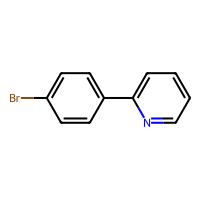
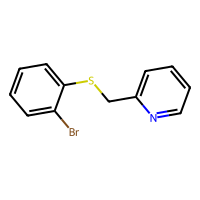
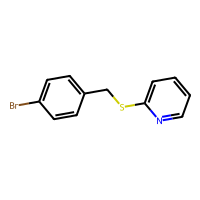
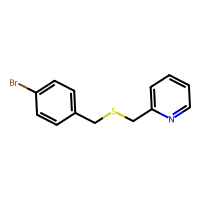
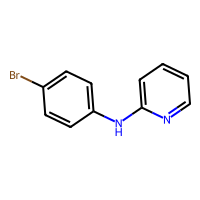
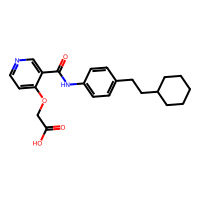
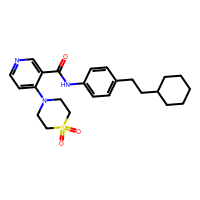
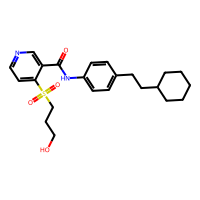
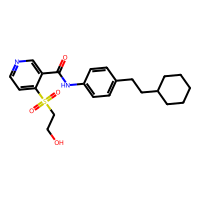
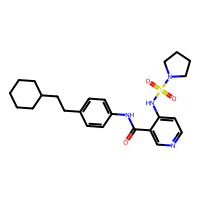

In [23]:
cs

In [ ]:
# # finish with greedy selection
# cs.model = Model.gaussian_process()
# cs.query = Query.Greedy()

# picks = cs.active_learning(50)
# picks_results = cs.evaluate(picks, num_conf=50, gnina_gpu=True, penalty=0.0, al_ignore_penalty=False)

# # save the new results
# picks_results.to_csv('notebook_greedy_results.csv')

# # save the entire chemical space with all the results
# cs.to_sdf('notebook_chemspace-greedy.sdf')

#### Export the Chemical Space to SDF (with build-status filters)

In this step, the curated chemical space is exported to an SDF file while applying filters and embedding metadata for traceability. An integer index tag is also added to each entry to preserve a direct link between the SDF file and the original DataFrame row, allowing for easy reference and data tracking. 

In [24]:
failed=False
unbuilt=False

with Chem.SDWriter('notebook_chemspace.sdf') as SD:
    columns = cs.df.columns.to_list()
    columns.remove("Mol")

    for i, row in cs.df.iterrows():

    # ignore this molecule because it failed during the build
        if failed is False and row.Success is False:
            continue

    # ignore this molecule because it was not built yet
        if unbuilt is False and row.Success != True:
            continue

        mol = row.Mol
        mol.SetIntProp("index", i)
        for column in columns:
            value = getattr(row, column)
            mol.SetProp(column, str(value))

        mol.ClearProp("attachement_point")
        SD.write(mol)

#### Extract and Save the Top-Scoring Molecules

In this step, the generated SDF file is read to select only successfully built molecules. Invalid entries are skipped, and the remaining compounds are ranked by their score to identify the top-performing candidates. The 100 highest-scoring molecules are then saved to a new SDF file.

In [25]:
# open the SDF
molecules = []
input_sdf = 'notebook_chemspace.sdf'
best_n = 100

with Chem.SDMolSupplier(input_sdf) as SDF:
    # for each mol
    for mol in SDF:
        if mol is None:
            continue
        if mol.GetPropsAsDict()['Success'] == 'True':
            molecules.append(mol)

# sort by the key
sorted_molecules = sorted(molecules, key=lambda m: m.GetPropsAsDict()['score'], reverse=True)

with Chem.SDWriter(f"top_{best_n:d}_{input_sdf}") as SDF_OUT:
    for i, mol in enumerate(sorted_molecules):
        if i == best_n:
            break

        SDF_OUT.write(mol)

print('Done')

Done
